



&nbsp;

__DSC680_APPLIED DATA SCIENCE_SUMMER2025__



&nbsp;

__Week 10- Project Milestone-III__
&nbsp;

__Project Title: QUANTIFYING ENERGY BURDEN IN THE UNITED STATES__
&nbsp;

__Subtitle : A State-Level Assessment of Electricity Affordability and Climate Impact__

&nbsp;

__Phase : PROJECT MILESTONE III: Code__


&nbsp;

__Author : Sayali Nage__
&nbsp;

__Date Created(Ver1) : 08/04/2025__
&nbsp;

__Instructor : Matthew Metzger__

&nbsp;

__BELLEVUE UNIVERSITY, NEBRASKA(NE)__

%%latex
\newpage

__Energy Burden Analysis: Data Processing, EDA, and Model Interpretability__

This notebook performs a comprehensive analysis of energy burden, integrating climate, energy sales, and household income data to identify key drivers and interpret model predictions.

# Environment Setup

This section sets up the necessary libraries and general configurations for the analysis.

In [1]:
# pip install adjustText

In [2]:
# pip install us

In [3]:
# pip install shap

In [4]:
# pip install tabulate

In [5]:
# Standard libraries
import os
import pandas as pd
import numpy as np
import ast
import requests
import re
import time
import us
import glob
import tabulate
import calendar
from datetime import datetime, timedelta, timezone 
from dateutil import parser
from tqdm import tqdm
import warnings

# Correlartion and Regression
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import shap
import io
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import matplotlib
import plotly.graph_objects as go
from adjustText import adjust_text
from textwrap import wrap, fill

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# Dataset Setup 

## Import Raw Datasets

This section focuses on loading the raw datasets from their respective file paths.

In [6]:
# Set working directory for data files
data_dir = os.path.join(os.getcwd(), "data")

In [7]:
# Load NOAA Climate Data (Unprocessed)
climate_filepath = os.path.join(data_dir, "monthly_state_climate_data_2021_2023.csv")
climate_df = pd.read_csv(climate_filepath)

climate_df.head()

,Year,Month,State,cdd,hdd,pcp,tavg,tmax,tmin
0,2021,2,Alabama,3.0,547.0,4.22,46.7,57.7,35.8
1,2021,2,Alaska,NaN,NaN,1.93,1.0,8.6,-6.6
2,2021,2,Arizona,10.0,320.0,0.23,46.5,60.6,32.4
3,2021,2,Arkansas,0.0,869.0,3.40,34.8,43.7,26.0
4,2021,2,California,0.0,406.0,1.39,47.4,58.7,36.0


In [8]:
# Load EIA Sales and Revenue Data (Unprocessed)
eia_filepath = os.path.join(data_dir, "sales_revenue.xlsx")
eia_df = pd.read_excel(eia_filepath, sheet_name="Monthly-States", engine='openpyxl', header=[0, 1, 2])

eia_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
  Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1 Unnamed: 3_level_1   
                Year              Month              State        Data Status   
0               2025                4.0                 AK        Preliminary   
1               2025                4.0                 AL        Preliminary   
2               2025                4.0                 AR        Preliminary   
3               2025                4.0                 AZ        Preliminary   
4               2025                4.0                 CA        Preliminary   

       RESIDENTIAL                                           COMMERCIAL  \
           Revenue         Sales   Customers     Price          Revenue   
  Thousand Dollars Megawatthours       Count Cents/kWh Thousand Dollars   
0         41954.56      161624.5    301774.0     25.96         46908.63   
1        348725.99     2080965.1   2420894.0     16.76        253522.72   
2        150494.59     1105649.0   1491695.0     13.61         94905.82   
3        374418.32     2380634.3   3146065.0     15.73        346023.98   
4       1746821.90     5497999.8  14405178.0     31.77       2071943.80   

                 ... INDUSTRIAL             TRANSPORTATION                \
          Sales  ...  Customers     Price          Revenue         Sales   
  Megawatthours  ...      Count Cents/kWh Thousand Dollars Megawatthours   
0     211664.88  ...     1233.0     20.01             0.00          0.00   
1    1739004.10  ...     7247.0      7.81             0.00          0.00   
2     857351.72  ...    30229.0      6.39             2.90         23.64   
3    2848985.80  ...     7189.0      7.87            96.00        899.74   
4    8496636.40  ...   148868.0     18.07          8853.43      56728.87   

                                 TOTAL                                      
  Customers     Price          Revenue         Sales   Customers     Price  
      Count Cents/kWh Thousand Dollars Megawatthours       Count Cents/kWh  
0       0.0      0.00        112367.69     490782.42    361102.0     22.90  
1       0.0      0.00        811799.07    6501905.30   2823250.0     12.49  
2       2.0     12.28        358715.65    3735015.70   1731436.0      9.60  
3       2.0     10.67        807724.17    6338973.50   3502426.0     12.74  
4      13.0     15.61       4406925.30   17257378.00  16351719.0     25.54  

[5 rows x 24 columns]

In [9]:
# Load ACS Median Household Income Data (Unprocessed-separate datasets for years 2021-2023)
years = [2021, 2022, 2023]

acs_data = {}
for year in years:
    # Match the beginning of the filename
    pattern = os.path.join(data_dir, f"ACSST1Y{year}*.csv")
    files = glob.glob(pattern)
    
    if files:
        acs_data[year] = pd.read_csv(files[0])  # Assume first match is correct
        print(f"Loaded: {files[0]}")
    else:
        print(f"No file found for {year}")
        
acs_2021, acs_2022, acs_2023 = [acs_data[year] for year in years]

Loaded: /home/jovyan/work/DSC_680/data/ACSST1Y2021.S1903-2025-07-23T154714.csv
Loaded: /home/jovyan/work/DSC_680/data/ACSST1Y2022.S1903-2025-07-23T154650.csv
Loaded: /home/jovyan/work/DSC_680/data/ACSST1Y2023.S1903-2025-07-23T154807.csv


In [10]:
acs_2021.head()

,Label (Grouping),Alabama!!Number!!Estimate,Alabama!!Number!!Margin of Error,Alabama!!Percent Distribution!!Estimate,Alabama!!Percent Distribution!!Margin of Error,Alabama!!Median income (dollars)!!Estimate,Alabama!!Median income (dollars)!!Margin of Error,Alaska!!Number!!Estimate,Alaska!!Number!!Margin of Error,Alaska!!Percent Distribution!!Estimate,...,Wyoming!!Percent Distribution!!Estimate,Wyoming!!Percent Distribution!!Margin of Error,Wyoming!!Median income (dollars)!!Estimate,Wyoming!!Median income (dollars)!!Margin of Error,Puerto Rico!!Number!!Estimate,Puerto Rico!!Number!!Margin of Error,Puerto Rico!!Percent Distribution!!Estimate,Puerto Rico!!Percent Distribution!!Margin of Error,Puerto Rico!!Median income (dollars)!!Estimate,Puerto Rico!!Median income (dollars)!!Margin of Error
0,HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATIN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Households,"1,967,559","±10,527","1,967,559","±10,527","53,913",±781,"271,311","±3,313","271,311",...,"242,763","±2,909","65,204","±2,744","1,165,982","±9,161","1,165,982","±9,161","22,237",±478
2,One race--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,White,"1,319,637","±9,283",67.1%,±0.3,"62,496",±971,"186,669","±3,461",68.8%,...,87.8%,±0.9,"67,124","±3,185","321,054","±7,520",27.5%,±0.6,"21,782",±748
4,Black or African American,"511,624","±6,588",26.0%,±0.3,"36,058",±927,N,N,N,...,N,N,"45,376","±30,436","70,613","±5,027",6.1%,±0.4,"22,156","±1,656"


## Raw Dataset Preprocessing (Exploratory Metadata Handling)

This section defines and applies initial preprocessing steps specific to each raw dataset's structure.

### Energy Sales and Revenue in Residential Sector

The unprocessed EIA Dataset has monthly records for Revenue(US Dollars), Energy Sales(MWh), Customers(Count), Price(Cents/kWh) for each state in US from 2010 to date. Upon inspection, the first 8 rows contains records for Residential sector which metts the projet goal. Therefore in this section, the 2nd row and first 8 columns will be selected to store the subset as energy dataset to be used throughout the project. 

Actual data cleaning and preparation techniques will be applied in later stages.

In [11]:
# Drop the first two rows (metadata/header rows) and keep only the first 8 columns (i.e., for residential summary)
eia_processed = eia_df.iloc[2:, :8].copy()

# Reset index
eia_processed.reset_index(drop=True, inplace=True)

# Rename columns for clarity
eia_processed.columns = [
    "Year",
    "Month",
    "State",
    "Data_Status",
    "Revenue_thousand_dollars",
    "Sales_MWh",
    "Customers_count",
    "Price_Cents_per_kWh"
]

eia_processed.head()

,Year,Month,State,Data_Status,Revenue_thousand_dollars,Sales_MWh,Customers_count,Price_Cents_per_kWh
0,2025,4.0,AR,Preliminary,150494.59,1105649.00,1491695.0,13.61
1,2025,4.0,AZ,Preliminary,374418.32,2380634.30,3146065.0,15.73
2,2025,4.0,CA,Preliminary,1746821.90,5497999.80,14405178.0,31.77
3,2025,4.0,CO,Preliminary,219278.40,1404662.90,2511198.0,15.61
4,2025,4.0,CT,Preliminary,275807.10,854376.35,1569228.0,32.28


### ACS Data for Median Houshold Income

The unprocessed EIA Dataset has statewide annual median household records in the United States. Upon investigation it was found that, the dataset has "Label" set as index which provide income disparities across various groupd such as, race, age, family settings. This section processes the index to exctract categoris and subcategoris and unpivot a DataFrame from wide format to long format. This technique is applied for all individual ACS dataset and results in merging them into a single processed ACS dataset.

* Household Income by Race and Hispanic or Latino Origin of Householder

| Category                                      | SubCategory                                  |
|----------------------------------------------|----------------------------------------------|
| Household Income                             | All Household                                 |
| Household Income by Race of Householder      | Onerace White                                 |
| Household Income by Race of Householder      | Onerace Black or African American             |
| Household Income by Race of Householder      | Onerace American Indian and Alaska Native     |
| Household Income by Race of Householder      | Onerace Asian                                 |
| Household Income by Race of Householder      | Onerace Native Hawaiian and Other Pacific Islander |
| Household Income by Race of Householder      | Onerace Some other race                       |
| Household Income by Race of Householder      | Two or more races                             |
| Household Income by Race of Householder      | Hispanic or Latino origin (of any race)       |
| Household Income by Race of Householder      | White alone, not Hispanic or Latino           |

* Household Income by Age of Householder

| Category           | SubCategory         |
|-------------------|---------------------|
| 15 to 24 years     | All 15 to 24 years  |
| 25 to 44 years     | All 25 to 44 years  |
| 45 to 64 years     | All 45 to 64 years  |
| 65 years and over  | All 65 years and over |

* Families

| Category                          | SubCategory                                     |
|----------------------------------|-------------------------------------------------|
| Families                         | All families                                    |
| Families                         | With own children of householder under 18 years |
| Families                         | With no own children of householder under 18 years |
| Married-couple families          | All Married-couple families                     |
| Married-couple families          | With own children under 18 years                |
| Female householder, no spouse present | All Female householder, no spouse present   |
| Female householder, no spouse present | With own children under 18 years           |
| Male householder, no spouse present   | All Male householder, no spouse present     |
| Male householder, no spouse present   | With own children under 18 years           |

* Family Income by Family Size

| Category              | SubCategory           |
|----------------------|-----------------------|
| 2-person families     | All 2-person families |
| 3-person families     | All 3-person families |
| 4-person families     | All 4-person families |
| 5-person families     | All 5-person families |
| 6-person families     | All 6-person families |
| 7-or-more person families | All 7-or-more person families |

* Family Income by Number of Earners

| Category          | SubCategory       |
|------------------|-------------------|
| No earners        | All No earners    |
| 1 earner          | All 1 earner      |
| 2 earners         | All 2 earners     |
| 3 or more earners | All 3 or more earners |

* Nonfamily Households

| Category                          | SubCategory                          |
|----------------------------------|--------------------------------------|
| Nonfamily households             | All Nonfamily households             |
| Female householder               | All Female householder               |
| Female householder Living alone  | All Female householder Living alone  |
| Female householder Not living alone | All Female householder Not living alone |
| Male householder                 | All Male householder                 |
| Male householder Living alone    | All Male householder Living alone    |
| Male householder Not living alone | All Male householder Not living alone |



Actual data cleaning and preparation techniques will be applied in later stages.

In [12]:
def is_all_caps(text):
    return text.isupper() and not text.isnumeric()

In [13]:
# Function to create Category and subcategory columns in ACS Income dataset
def transform_labels(df):
    group = category = subcategory = None
    labels_out = []
    group_labels = []
    category_labels = []
    subcategory_labels = []

    for label in df["Label"]:
        label = str(label).strip()

        # Detect new group (all caps)
        if is_all_caps(label):
            group = label
            category = subcategory = None
            continue

        # Assign default in case it's a weird edge case
        subcategory = None

        # Label-specific logic (check category/subcategory assignment logic in markdown)
        if group == "HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER":
            category = "Household Income by Race of Householder"
            if label.endswith("--"):
                subcategory = None  # placeholder
            elif "One race" in label or any(x in label for x in ["White", "Black", "Asian", "Pacific Islander", "Some other race", "American Indian"]):
                subcategory = f"Onerace {label}"
            elif "Household" in label:
                subcategory = f"All {label}"
            else:
                subcategory = label

        elif group == "HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER":
            category = "Household Income by Age of Householder"
            subcategory = None if label.endswith("--") else label

        elif group == "FAMILIES":
            category = "Family Based Household Dynamics"
            if label.endswith("--"):
                subcategory = None
            elif "With own children" in label or "With no own children" in label:
                subcategory = f"Families {label}"
            elif "Married-couple" in label:
                subcategory = "Married-Couple Families"
            elif "Female householder" in label:
                subcategory = "Family of Female householder, no spouse present"
            elif "Male householder" in label:
                subcategory = "Family of Male householder, no spouse present"
            else:
                subcategory = "All Families" if "Families" in label else label

        elif group == "FAMILY INCOME BY FAMILY SIZE":
            category = "Family Income by Family Size"
            subcategory = None if label.endswith("--") else f"All {label}"

        elif group == "FAMILY INCOME BY NUMBER OF EARNERS":
            category = "Family Income by Number of Earners"
            subcategory = None if label.endswith("--") else f"Family with {label}"

        elif group == "NONFAMILY HOUSEHOLDS":
            category = "Non-Family Based Household Dynamics"
            if label.endswith("--"):
                subcategory = None
            elif "Living alone" in label or "Not living alone" in label:
                subcategory = f"Householder {label}"
            elif "Female householder" in label:
                subcategory = "Female householder"
            elif "Male householder" in label:
                subcategory = "Male householder"
            else:
                subcategory = "All Nonfamily households" if "Nonfamily households" in label else label

        # Collect if it's not a group row
        labels_out.append(label)
        group_labels.append(group)
        category_labels.append(category)
        subcategory_labels.append(subcategory)

    # Filter only non-all-caps rows (group headers)
    df_filtered = df[~df["Label"].apply(lambda x: is_all_caps(str(x).strip()))].copy()
    df_filtered["Group"] = group_labels
    df_filtered["Category"] = category_labels
    df_filtered["Subcategory"] = subcategory_labels

    return df_filtered

In [14]:
# Function to clean and transform ACS incoem Raw dataset for metadata handling
def clean_and_transform(df, year):
    df = df.loc[:, ~df.columns.str.contains("Margin of Error")].copy()
    df_long = df.melt(id_vars=["Label (Grouping)"], 
                        var_name="State_Metric", 
                        value_name="Value")
    df_long[["State", "MetricType", "Measure"]] = df_long["State_Metric"].str.split("!!", expand=True)
    df_long = df_long[df_long["Measure"] == "Estimate"]
    
    metric_map = {
    "Number": "Household_Count",
    "Percent Distribution": "Percent_Distribution",
    "Median income (dollars)": "Median_HH_Income"
    }
    df_long["Metric"] = df_long["MetricType"].map(metric_map)

    df_long["Year"] = year

    df_clean = df_long.rename(columns={"Label (Grouping)": "Label", "MetricType":"Unit"})
    df_clean = df_clean[["Year", "State", "Label", "Metric", "Value", "Unit" ]]

    df_transformed = transform_labels(df_clean)
    # Drop any rows where Subcategory is still None
    df_transformed = df_transformed[df_transformed["Subcategory"].notna()]
    df_transformed.drop(columns=["Label", "Group"], inplace=True)
    return df_transformed  

In [15]:
# Apply preprocessing function sto add dataframes and merge to combine all years(2021-2023)
acs_processed = pd.concat([
    clean_and_transform(acs_2021, 2021),
    clean_and_transform(acs_2022, 2022),
    clean_and_transform(acs_2023, 2023)
], ignore_index=True)

In [16]:
acs_processed.head()

,Year,State,Metric,Value,Unit,Category,Subcategory
0,2021,Alabama,Household_Count,"1,967,559",Number,Household Income by Race of Householder,All Households
1,2021,Alabama,Household_Count,"1,319,637",Number,Household Income by Race of Householder,Onerace White
2,2021,Alabama,Household_Count,"511,624",Number,Household Income by Race of Householder,Onerace Black or African American
3,2021,Alabama,Household_Count,"8,196",Number,Household Income by Race of Householder,Onerace American Indian and Alaska Native
4,2021,Alabama,Household_Count,"22,409",Number,Household Income by Race of Householder,Onerace Asian


In [17]:
acs_processed["Unit"].unique()

array(['Number', 'Percent Distribution', 'Median income (dollars)'],
      dtype=object)

In [18]:
acs_processed["Metric"].unique()

array(['Household_Count', 'Percent_Distribution', 'Median_HH_Income'],
      dtype=object)

In [19]:
# Show just the problematic entries
acs_processed[~acs_processed["Value"].str.replace(".", "", 1).str.isnumeric()]["Value"].value_counts()

Value
N          494
2.9%        45
1.5%        37
8.1%        34
3.1%        30
          ... 
90,896       1
227,783      1
422,979      1
709,344      1
31,988       1
Name: count, Length: 12721, dtype: int64

In [20]:
acs_processed["Value"].min()

'-'

In [21]:
acs_processed["Value"].max()

'N'

In [22]:
print(acs_processed.groupby(['Category', 'Subcategory']).size().sort_values(ascending=False))

Category                                 Subcategory                                                
Family Based Household Dynamics          Families With own children under 18 years                      1404
Non-Family Based Household Dynamics      Householder Not living alone                                    936
                                         Householder Living alone                                        936
Family Based Household Dynamics          All Families                                                    468
Household Income by Race of Householder  Onerace Native Hawaiian and Other Pacific Islander              468
                                         All Households                                                  468
                                         Hispanic or Latino origin (of any race)                         468
                                         Onerace American Indian and Alaska Native                       468
                           

In [23]:
print(acs_processed[acs_processed['Category'] == 'Household Income by Race of Householder'].head(10))

   Year    State           Metric      Value    Unit  \
0  2021  Alabama  Household_Count  1,967,559  Number   
1  2021  Alabama  Household_Count  1,319,637  Number   
2  2021  Alabama  Household_Count    511,624  Number   
3  2021  Alabama  Household_Count      8,196  Number   
4  2021  Alabama  Household_Count     22,409  Number   
5  2021  Alabama  Household_Count          N  Number   
6  2021  Alabama  Household_Count     28,019  Number   
7  2021  Alabama  Household_Count     76,657  Number   
8  2021  Alabama  Household_Count     62,323  Number   
9  2021  Alabama  Household_Count  1,307,851  Number   

                                  Category  \
0  Household Income by Race of Householder   
1  Household Income by Race of Householder   
2  Household Income by Race of Householder   
3  Household Income by Race of Householder   
4  Household Income by Race of Householder   
5  Household Income by Race of Householder   
6  Household Income by Race of Householder   
7  Household In

# DATA CLEANING & PREPARATION

## Create Independent DataFrames

In [24]:
state_climate_df = climate_df.copy()
res_energy_df = eia_processed.copy()
ah_income_df = acs_processed.copy()

In [25]:
print("\033[1mClimate Data\033[0m")
state_climate_df.info()
print("\n\033[1mEIA Energy Data\033[0m")
res_energy_df.info()
print("\n\033[1mACS Income Data\033[0m")
ah_income_df.info()

Climate Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    1650 non-null   int64  
 1   Month   1650 non-null   int64  
 2   State   1650 non-null   object 
 3   cdd     1584 non-null   float64
 4   hdd     1584 non-null   float64
 5   pcp     1650 non-null   float64
 6   tavg    1650 non-null   float64
 7   tmax    1650 non-null   float64
 8   tmin    1650 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 116.1+ KB

EIA Energy Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9383 entries, 0 to 9382
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      9383 non-null   object 
 1   Month                     9382 non-null   float64
 2   State                     9382 non-null   object 
 3   Data_St

## General-Purpose Cleaning Functions

__Standardize Column Names__

In [26]:
# Function to lowercase all column names
def standardize_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

__Standardize state fields__

In [27]:
# US State Reference mapping
STATE_LOOKUP = pd.DataFrame(
    [(state.abbr, state.name) for state in us.states.STATES],
    columns=["state_code", "state_name"]
)

In [28]:
# Inspected missing values-Ensure DC and PR are included
extra_states = pd.DataFrame({
    "state_name": ["District Of Columbia", "Puerto Rico"],
    "state_code": ["DC", "PR"]
})

# Add and drop duplicates if needed
STATE_LOOKUP = pd.concat([STATE_LOOKUP, extra_states], ignore_index=True).drop_duplicates()

In [29]:
# Creates statename and state code columns in all datasets for uniformaty
def standardize_state_fields(df):
    if 'state' not in df.columns:
        return df
    df['state'] = df['state'].str.strip()
    if df['state'].str.len().max() == 2:
        df = df.merge(STATE_LOOKUP, how='left', left_on='state', right_on='state_code')
    else:
        df['state'] = df['state'].str.title()
        df = df.merge(STATE_LOOKUP, how='left', left_on='state', right_on='state_name')
    return df

__Convert Year and Month to Integers__

In [30]:
# Create to convert datatype
def convert_year_month_to_int(df):
    for col in ['year', 'month']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    return df

__Filter to 2021–2023__

In [31]:
# Function to select/ensure 2-2102-23 years are selected for analysis
def filter_years(df, start=2021, end=2023):
    if "year" in df.columns:
        return df[(df["year"] >= start) & (df["year"] <= end)]
    return df

__Convert 'value' column to float (ACS specific)__

In [32]:
# Function to strip special characters in headers if any
def clean_value_column(df):
    df = df.copy()
    
    def safe_convert(val):
        if isinstance(val, str):
            val = val.replace(",", "").replace("%", "")
            try:
                return float(val)
            except ValueError:
                return None
        return val
    
    df["value"] = df["value"].apply(safe_convert)
    return df

__Combine All into a Pipeline Function__

In [33]:
# Function to run pipeline for easy processing(cleaning) multiple datasets
def clean_common_fields(df):
    df = standardize_column_names(df)
    df = standardize_state_fields(df)
    df = convert_year_month_to_int(df)
    df = filter_years(df)
    return df

__Usage__

In [34]:
# Apply General purple data cleaning functions on climate data
state_climate_df = clean_common_fields(state_climate_df)
print("\033[1mClimate Data\033[0m")
state_climate_df.info()

# Apply General purple data cleaning functions on resedential energy data
res_energy_df = clean_common_fields(res_energy_df)
print("\n\033[1mEIA Energy Data\033[0m")
res_energy_df.info()

# Apply General purple data cleaning functions on acs household income data
ah_income_df = clean_common_fields(ah_income_df)
ah_income_df = clean_value_column(ah_income_df)
print("\n\033[1mACS Income Data\033[0m")
ah_income_df.info()

Climate Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        1650 non-null   Int64  
 1   month       1650 non-null   Int64  
 2   state       1650 non-null   object 
 3   cdd         1584 non-null   float64
 4   hdd         1584 non-null   float64
 5   pcp         1650 non-null   float64
 6   tavg        1650 non-null   float64
 7   tmax        1650 non-null   float64
 8   tmin        1650 non-null   float64
 9   state_code  1650 non-null   object 
 10  state_name  1650 non-null   object 
dtypes: Int64(2), float64(6), object(3)
memory usage: 145.1+ KB

EIA Energy Data
<class 'pandas.core.frame.DataFrame'>
Index: 1836 entries, 814 to 2649
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      1836 non-null   Int64

In [35]:
state_climate_df.head()

,year,month,state,cdd,hdd,pcp,tavg,tmax,tmin,state_code,state_name
0,2021,2,Alabama,3.0,547.0,4.22,46.7,57.7,35.8,AL,Alabama
1,2021,2,Alaska,NaN,NaN,1.93,1.0,8.6,-6.6,AK,Alaska
2,2021,2,Arizona,10.0,320.0,0.23,46.5,60.6,32.4,AZ,Arizona
3,2021,2,Arkansas,0.0,869.0,3.40,34.8,43.7,26.0,AR,Arkansas
4,2021,2,California,0.0,406.0,1.39,47.4,58.7,36.0,CA,California


In [36]:
res_energy_df.head()

,year,month,state,data_status,revenue_thousand_dollars,sales_mwh,customers_count,price_cents_per_kwh,state_code,state_name
814,2023,12,AK,Final,51237.89,211543.65,296928.0,24.22,AK,Alaska
815,2023,12,AL,Final,376876.37,2662008.40,2354106.0,14.16,AL,Alabama
816,2023,12,AR,Final,171935.62,1489393.10,1466787.0,11.54,AR,Arkansas
817,2023,12,AZ,Final,348174.75,2415126.40,3102198.0,14.42,AZ,Arizona
818,2023,12,CA,Final,1906136.00,6546374.70,14151928.0,29.12,CA,California


In [37]:
ah_income_df.head()

,year,state,metric,value,unit,category,subcategory,state_code,state_name
0,2021,Alabama,Household_Count,1967559.0,Number,Household Income by Race of Householder,All Households,AL,Alabama
1,2021,Alabama,Household_Count,1319637.0,Number,Household Income by Race of Householder,Onerace White,AL,Alabama
2,2021,Alabama,Household_Count,511624.0,Number,Household Income by Race of Householder,Onerace Black or African American,AL,Alabama
3,2021,Alabama,Household_Count,8196.0,Number,Household Income by Race of Householder,Onerace American Indian and Alaska Native,AL,Alabama
4,2021,Alabama,Household_Count,22409.0,Number,Household Income by Race of Householder,Onerace Asian,AL,Alabama


## Dataframe Specific Cleaning

### Climate Data

__Rename Columns to Improve Readability__

In [38]:
# Rename columns
state_climate_df.rename(columns={
    "cdd": "cooling_degree_days",
    "hdd": "heating_degree_days",
    "pcp": "precipitation_inches",
    "tavg": "temp_avg_f",
    "tmax": "temp_max_f",
    "tmin": "temp_min_f"
}, inplace=True)

In [39]:
# Find states with NaNs for cooling_degree_days
cooling_nan_states = state_climate_df[state_climate_df["cooling_degree_days"].isna()]["state"].value_counts()

# Find states with NaNs for heating_degree_days
heating_nan_states = state_climate_df[state_climate_df["heating_degree_days"].isna()]["state"].value_counts()

print("States with missing Cooling Degree Days:\n", cooling_nan_states)
print("\nStates with missing Heating Degree Days:\n", heating_nan_states)

States with missing Cooling Degree Days:
 state
Alaska    33
Hawaii    33
Name: count, dtype: int64

States with missing Heating Degree Days:
 state
Alaska    33
Hawaii    33
Name: count, dtype: int64


"Note: Alaska and Hawaii have missing degree day data, which is expected due to their climate profiles. No imputation will be performed for these columns.


### Energy Data

In [40]:
# EIA unmatched states
unmatched_eia_states = res_energy_df[res_energy_df["state_code"].isna()]["state"].unique()
print("Unmatched States in EIA:", unmatched_eia_states)

Unmatched States in EIA: []


In [41]:
res_energy_df = res_energy_df[res_energy_df["state"].notna()]

### ACS Income Data

In [42]:
# ACS unmatched states
unmatched_acs_states = ah_income_df[ah_income_df["state_code"].isna()]["state"].unique()
print("Unmatched States in ACS:", unmatched_acs_states)

Unmatched States in ACS: []


## Data Integration and Alignment

This section aligns the datasets by common states and prepares them for merging by keeping only rows from state column that are present in all three datasets.

In [43]:
ah_income_df["state_code"].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'], dtype=object)

In [44]:
state_climate_df["state_code"].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [45]:
res_energy_df["state_code"].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [46]:
# Find common state codes
common_state_codes = (
    set(res_energy_df["state_code"])
    & set(state_climate_df["state_code"])
    & set(ah_income_df["state_code"])
)

# Filter each DataFrame to only include shared states
res_energy_df = res_energy_df[res_energy_df["state_code"].isin(common_state_codes)]
state_climate_df = state_climate_df[state_climate_df["state_code"].isin(common_state_codes)]
ah_income_df = ah_income_df[ah_income_df["state_code"].isin(common_state_codes)]

In [47]:
res_energy_df = res_energy_df[res_energy_df["state_code"].isin(common_state_codes)]
state_climate_df = state_climate_df[state_climate_df["state_code"].isin(common_state_codes)]
ah_income_df = ah_income_df[ah_income_df["state_code"].isin(common_state_codes)]

In [48]:
# After clean_common_fields, assuming 'state' column still exists and is redundant
state_climate_df = state_climate_df.drop(columns=['state'])
res_energy_df = res_energy_df.drop(columns=['state'])
ah_income_df = ah_income_df.drop(columns=['state'])

# Exploratory Data Analysis:  Univariate Explorations

## Climate Data Overview (state_climate_df)

**Insight 1: Average Seasonal Temperature for Top Hottest and Coldest States (2021–2023)**

In [49]:
# Create data subset for plotting
avg_temp_by_state = state_climate_df.groupby("state_code")["temp_avg_f"].mean().sort_values()

# Select top 3 coldest and 3 hottest states
coldest_states = avg_temp_by_state.head(3).index.tolist()
hottest_states = avg_temp_by_state.tail(3).index.tolist()
selected_states = coldest_states + hottest_states

In [50]:
# Assign seasinal data from month column
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

state_climate_df["season"] = state_climate_df["month"].apply(month_to_season)


In [51]:
seasonal_avg_temp = (
    state_climate_df[state_climate_df["state_code"].isin(selected_states)]
    .groupby(["state_code", "season"])["temp_avg_f"]
    .mean()
    .reset_index()
)

In [52]:
season_order = ["Winter", "Spring", "Summer", "Fall"]

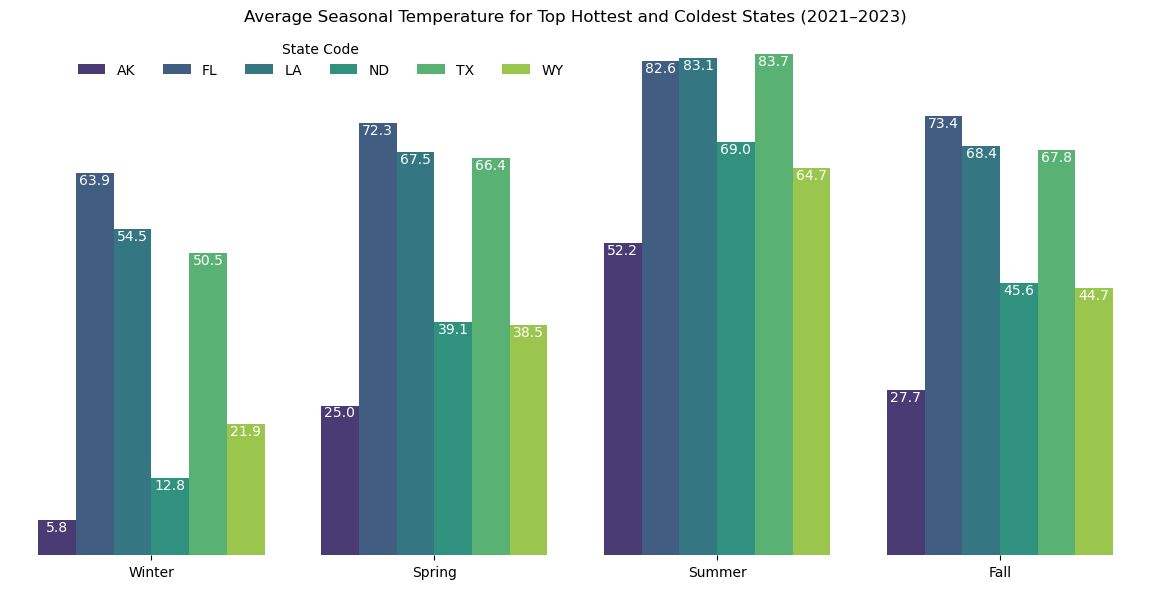

In [53]:
# Custom color palette using viridis
custom_palette = sns.color_palette("viridis", n_colors=len(selected_states))

# Plot the values
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=seasonal_avg_temp, x="season", y="temp_avg_f",
                 hue="state_code", palette=custom_palette, order=season_order)
# Add temperature labels on top of each bar
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.1f",
        label_type="edge",
        fontsize=10,
        color="white",
        padding=-10,   # Move label inside the bar
        # weight="bold"
    )
    
plt.title("Average Seasonal Temperature for Top Hottest and Coldest States (2021–2023)")

# Remove spines, axis labels, and y-ticks
sns.despine(left=True, bottom=True)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticks([])
# plt.xlabel("Season")
# plt.ylabel("Avg Temperature (F)")
# plt.legend(title="State Code")
plt.legend(title="State Code", loc="upper right", bbox_to_anchor=(0.5, 1), ncol=6,frameon=False)
plt.tight_layout()
plt.show()

### Insight 2: Distribution of Monthly Cooling Degree Days Across States (Box Plot)

In [54]:
# Sort states by median cooling degree days
median_cdd = state_climate_df.groupby("state_code")["cooling_degree_days"].mean().sort_values(ascending=False)
sorted_states = median_cdd.index.tolist()

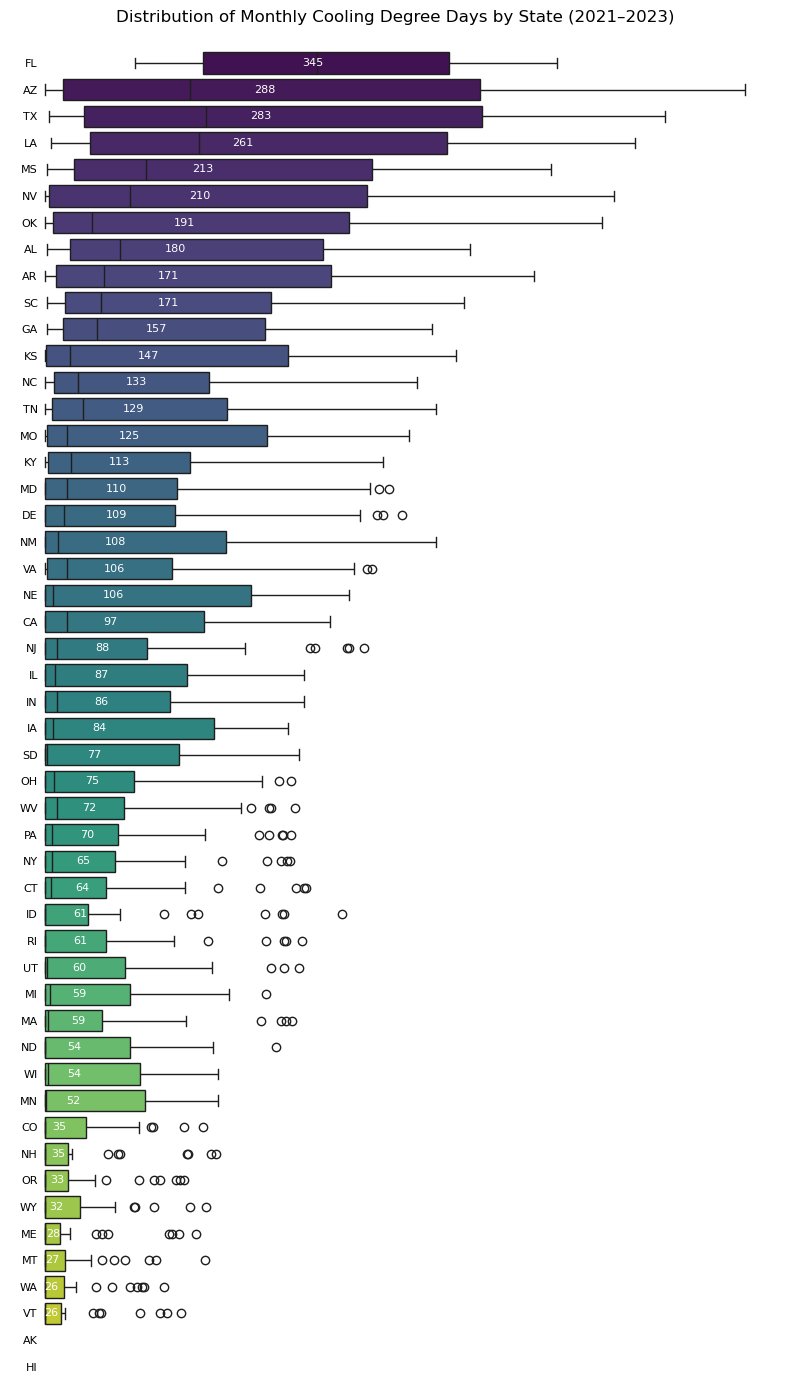

In [55]:
plt.figure(figsize=(8, 14))
ax = sns.boxplot(data=state_climate_df, y="state_code", x="cooling_degree_days", 
                 order=sorted_states, palette="viridis", orient="h")

# Add Personalizations
for state in sorted_states:
    median_value = median_cdd[state]
    if np.isfinite(median_value) and median_value > 0:
        ax.text(median_value - 10, state, f"{median_value:.0f}", color="white", ha="right", va="center", fontsize=8)

ax.tick_params(axis='y', pad=-20, length=0, labelsize=8)
plt.title("Distribution of Monthly Cooling Degree Days by State (2021–2023)", pad=20)
sns.despine(left=True, bottom=True)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])

plt.tight_layout()
plt.show()

### Insight 3: Relationship between Average Temperature and Cooling/Heating Degree Days (Scatter Plot)

In [56]:
state_climate_df['month'] = state_climate_df['month'].astype(int)
# Convert numeric month to full month name
state_climate_df["month_name"] = state_climate_df["month"].astype(int).map(lambda x: calendar.month_name[x])

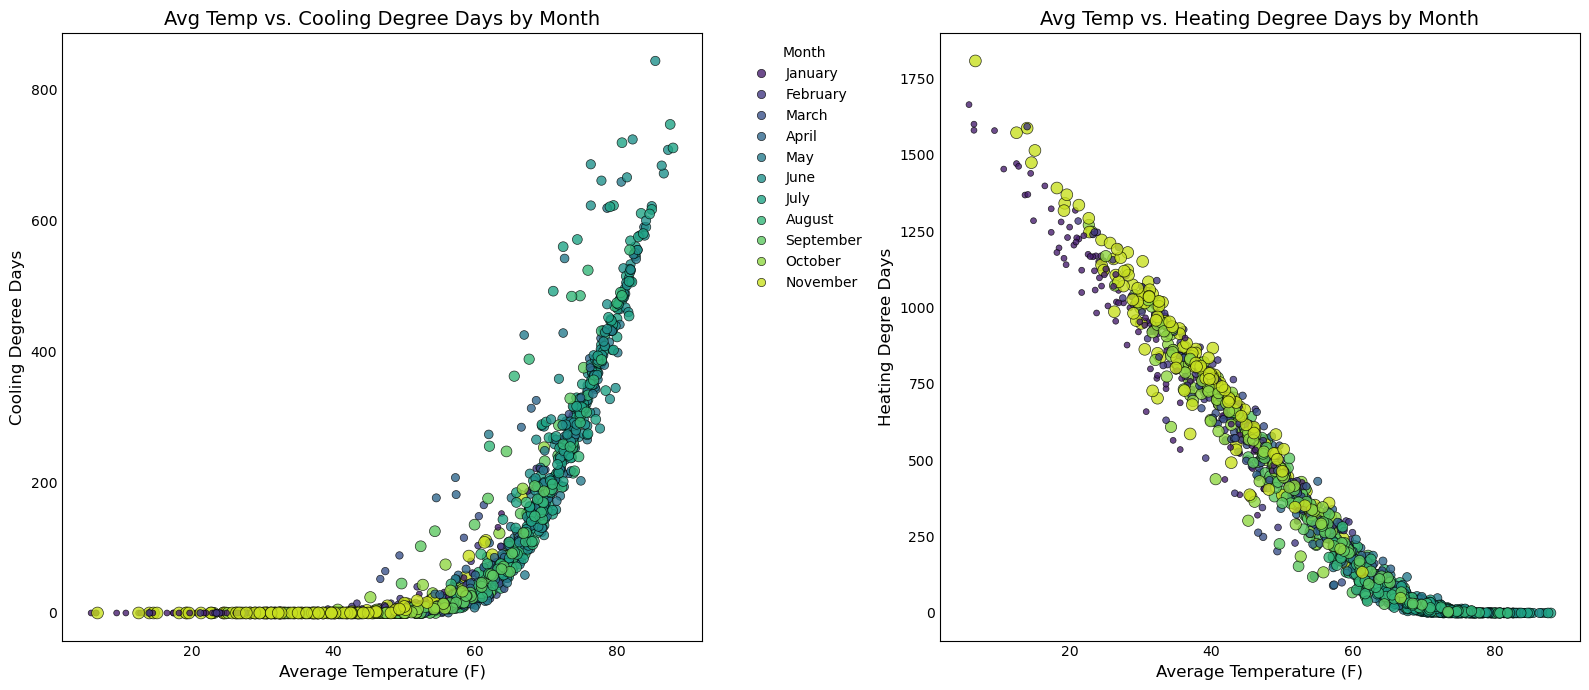

In [57]:
plt.figure(figsize=(16, 7))

# COOLING plot
plt.subplot(1, 2, 1)
cooling = sns.scatterplot(data=state_climate_df.dropna(subset=['temp_avg_f', 'cooling_degree_days']),
                          x='temp_avg_f', y='cooling_degree_days', hue='month_name', size=state_climate_df['month']*2, 
                          palette='viridis', alpha=0.8, edgecolor='black', linewidth=0.5)

# Remove size legend: keep only hue
handles, labels = cooling.get_legend_handles_labels()
month_labels = list(calendar.month_name[1:])  # Jan to Dec
month_handles = [h for h, l in zip(handles, labels) if l in month_labels]
plt.legend(month_handles, month_labels, bbox_to_anchor=(1.05, 1), loc=2, title='Month', frameon=False)

plt.title('Avg Temp vs. Cooling Degree Days by Month', fontsize=14)
plt.xlabel('Average Temperature (F)', fontsize=12)
plt.ylabel('Cooling Degree Days', fontsize=12)
plt.tick_params(axis='both', length=0)

# HEATING plot
plt.subplot(1, 2, 2)
sns.scatterplot(data=state_climate_df.dropna(subset=['temp_avg_f', 'heating_degree_days']),
                x='temp_avg_f', y='heating_degree_days', hue='month_name', size=state_climate_df['month']*2,
                palette='viridis', alpha=0.8, edgecolor='black', linewidth=0.5, legend=False)

plt.title('Avg Temp vs. Heating Degree Days by Month', fontsize=14)
plt.xlabel('Average Temperature (F)', fontsize=12)
plt.ylabel('Heating Degree Days', fontsize=12)
plt.tick_params(axis='both', length=0)

plt.tight_layout()
plt.show()


## EIA Electricity Data Overview (res_energy_df)

### Insight 1: Monthly Residential Price Trends for Selected States

In [58]:
# Compute average price per state
avg_prices = res_energy_df.groupby("state_code")["price_cents_per_kwh"].mean().sort_values()

## Select top 5 and bottom 5 states
# bottom_5 = avg_prices.head(5).index.tolist()
# top_5 = avg_prices.tail(5).index.tolist()
# selected_states = bottom_5 + top_5
top_10 = avg_prices.tail(10).index.tolist()


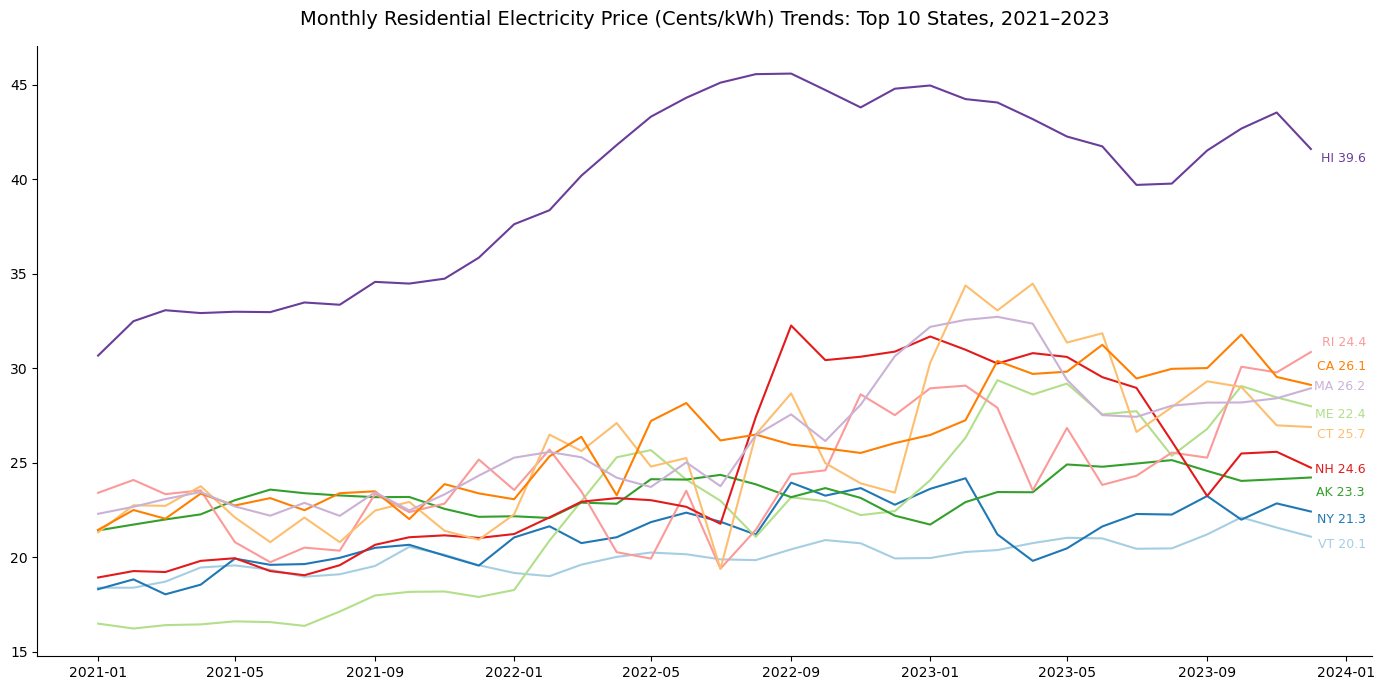

In [59]:
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Paired", len(top_10))

texts = []

# Create lineplot of monthly energy prices for top 10 states
for i, state_code in enumerate(top_10):
    state_data = res_energy_df[res_energy_df['state_code'] == state_code].copy()
    state_data = state_data.sort_values(by=['year', 'month'])
    state_data['date'] = pd.to_datetime(state_data['year'].astype(str) + '-' + state_data['month'].astype(str))

    sns.lineplot(data=state_data, x='date', y='price_cents_per_kwh', color=palette[i])

    last_row = state_data[state_data['date'].dt.year == 2023].iloc[-1]
    avg_price = state_data['price_cents_per_kwh'].mean()

    label_text = f"{state_code} {avg_price:.1f}"

    text = plt.text(
        last_row['date'] + pd.Timedelta(days=20),
        last_row['price_cents_per_kwh'],
        label_text,
        fontsize=9,
        color=palette[i],
        ha='left',
        va='center'
    )
    texts.append(text)

plt.title("Monthly Residential Electricity Price (Cents/kWh) Trends: Top 10 States, 2021–2023", fontsize=14, pad=15)
plt.xlabel("")
plt.ylabel("")
# Remove ticks and labels
# plt.xticks([])
# plt.yticks([])

# Show only bottom and left axis lines (spines)
sns.despine(top=True, right=True, left=False, bottom=False)
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-', color='white'))
# plt.legend(title="State Code", bbox_to_anchor=(0.01, 0.99), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

### Insight 2: Distribution of Residential Price per kWh Across States 

**(Summary barplot of median or mean price with error bars)**

In [60]:
state_stats = res_energy_df.groupby('state_code')['price_cents_per_kwh'].agg(['median', 'quantile'])

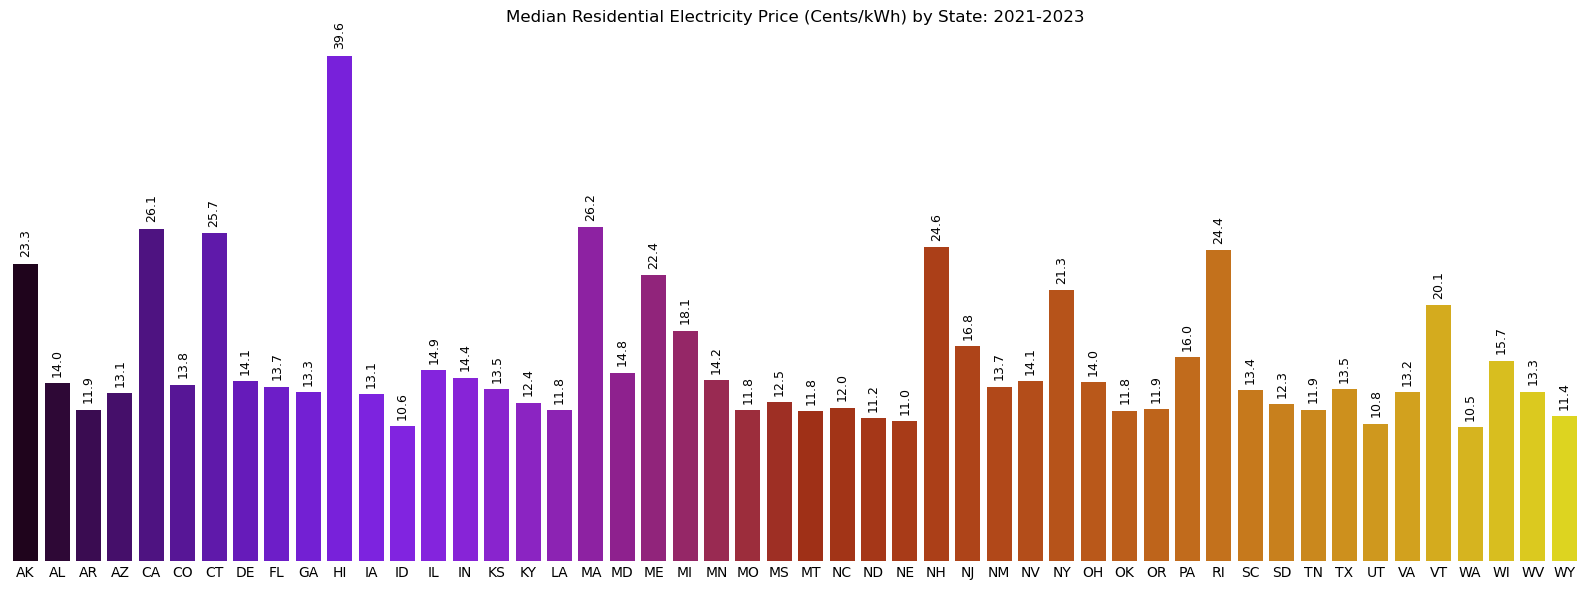

In [61]:
plt.figure(figsize=(16, 6))
ax=sns.barplot(data=res_energy_df, x='state_code', y='price_cents_per_kwh', ci=None , palette='gnuplot')
plt.title('Median Residential Electricity Price (Cents/kWh) by State: 2021-2023')

# Add Median energy price for each state above container
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 0.5,  # slight offset above bar
        f'{height:.1f}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=9
    )
plt.xlabel("")
plt.ylabel("")
plt.yticks([]) 
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Insight 3: Relationship between Customers and Sales (Monthly)

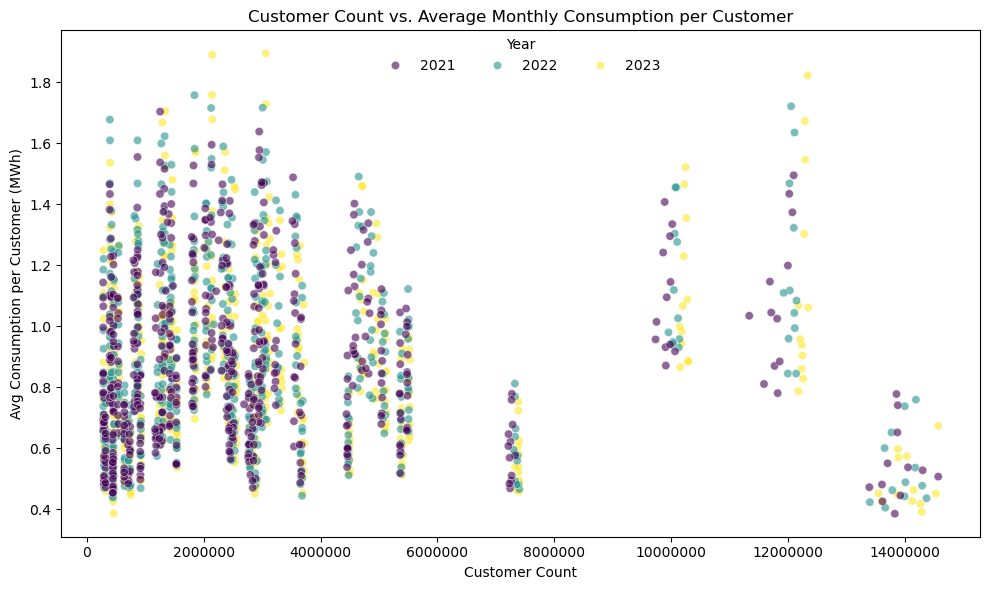

In [62]:
res_energy_df['avg_consumption_mwh'] = res_energy_df['sales_mwh'] / res_energy_df['customers_count']

plt.figure(figsize=(10,6))
sns.scatterplot(data=res_energy_df, x='customers_count', y='avg_consumption_mwh', hue='year', palette='viridis', alpha=0.6)
plt.title('Customer Count vs. Average Monthly Consumption per Customer')
plt.xlabel('Customer Count')
plt.ylabel('Avg Consumption per Customer (MWh)')
plt.ticklabel_format(style='plain', axis='x')
# plt.tick_params(axis='both', length=0)
plt.legend(title="Year", loc="center", bbox_to_anchor=(0.5, 0.95), ncol=3, frameon=False)
plt.tight_layout()
plt.show()

## ACS Income Data Overview (ah_income_df)

### Insight 1: Distribution of Median Household Income by Subcategory (Box Plot)

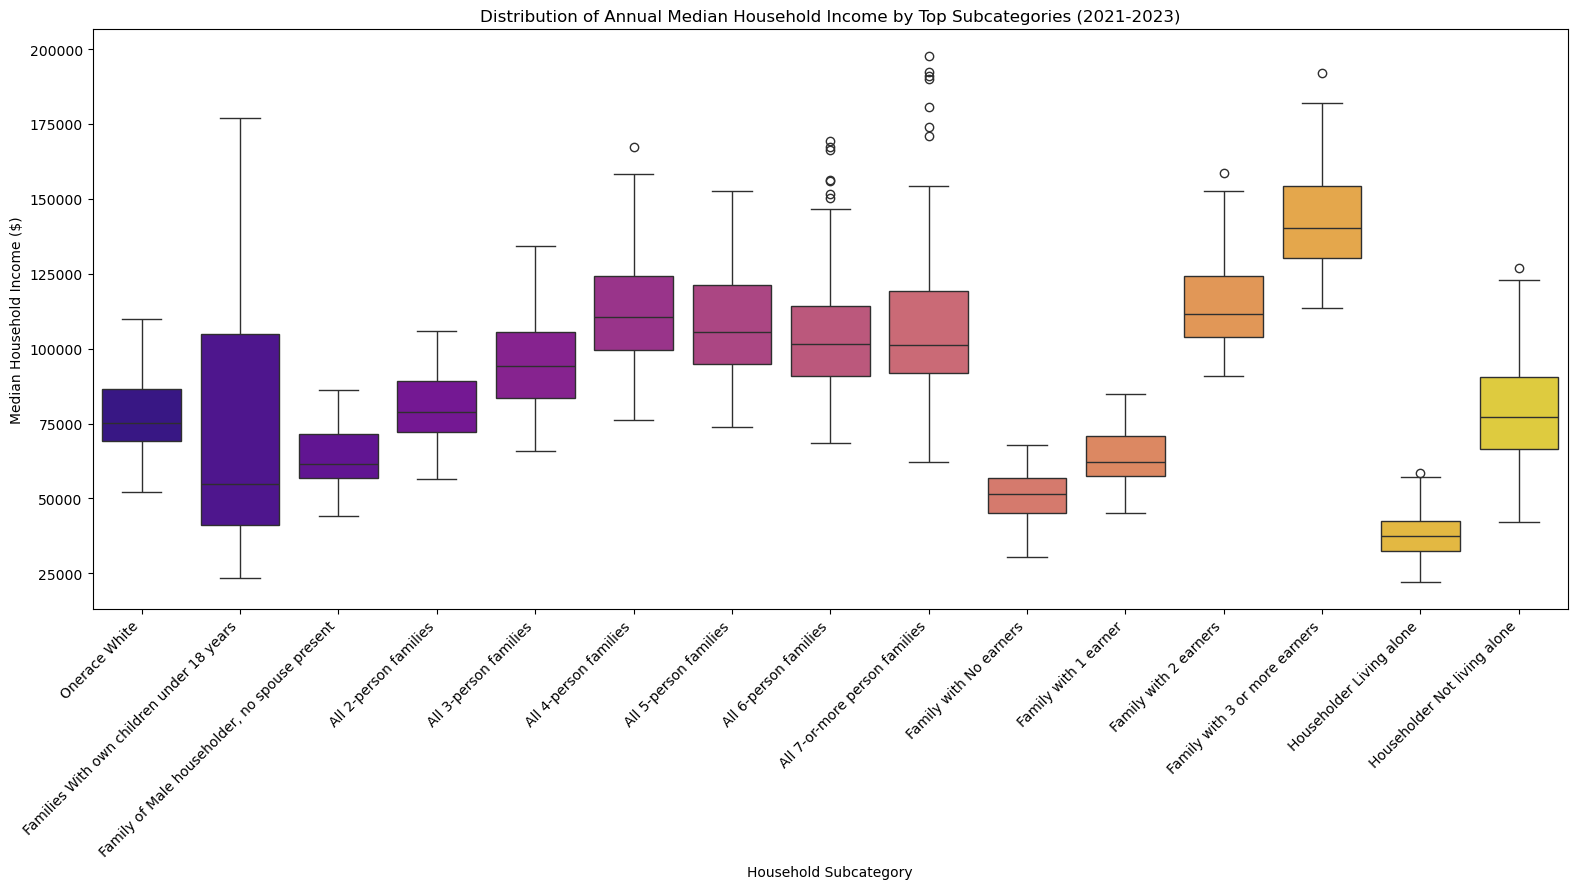

In [63]:
# It visualizes income disparities across different demographic groups.

top_subcategories = ah_income_df[ah_income_df['metric'] == 'Median_HH_Income']['subcategory'].value_counts().head(15).index.tolist()
income_data_for_plot = ah_income_df[
    (ah_income_df['metric'] == 'Median_HH_Income') &
    (ah_income_df['subcategory'].isin(top_subcategories))
].dropna(subset=['value'])

if not income_data_for_plot.empty:
    plt.figure(figsize=(16, 9))
    sns.boxplot(data=income_data_for_plot, x='subcategory', y='value', palette='plasma')
    plt.title('Distribution of Annual Median Household Income by Top Subcategories (2021-2023)')
    plt.xlabel('Household Subcategory')
    plt.ylabel('Median Household Income ($)')
    plt.xticks(rotation=45, ha='right')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No 'Median_HH_Income' data found for plotting by subcategory.")

### Insight 2: Median Household Income Trends for Selected States (All Households)

In [64]:
# Get latest available year data for median income (All Households)
latest_income = ah_income_df[
    (ah_income_df['metric'] == 'Median_HH_Income') &
    (ah_income_df['subcategory'] == 'All Households')
]
latest_year = latest_income['year'].max()

# Filter for latest year only
latest_income = latest_income[latest_income['year'] == latest_year]

# Sort by value
top_income_states = latest_income.sort_values(by='value', ascending=False)['state_code'].head(3).tolist()
bottom_income_states = latest_income.sort_values(by='value')['state_code'].head(3).tolist()

# Combine
selected_states_income = top_income_states + bottom_income_states

income_all_households_trends = ah_income_df[
    (ah_income_df['metric'] == 'Median_HH_Income') &
    (ah_income_df['subcategory'] == 'All Households') &
    (ah_income_df['state_code'].isin(selected_states_income))
].sort_values(by=['year'])

income_all_households_trends['year'] = income_all_households_trends['year'].astype(int)

# Prepare data
years = sorted(income_all_households_trends['year'].unique())
n_years = len(years)
unique_states = income_all_households_trends['state_code'].unique().tolist()
# Filter and reshape data for 3 subplots (1 per year)
years = sorted(income_all_households_trends['year'].unique())
n_years = len(years)

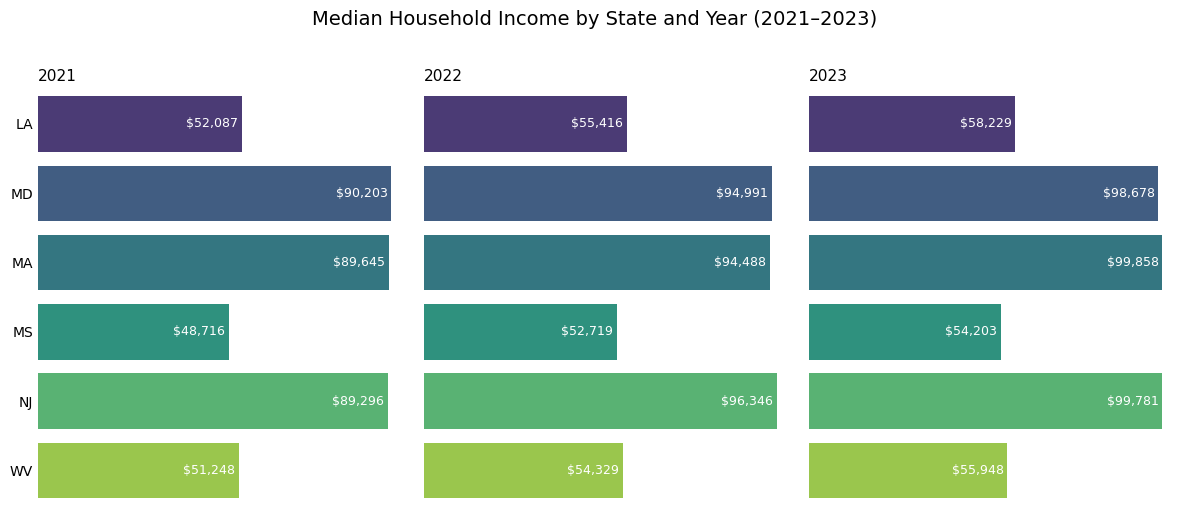

In [65]:
palette = sns.color_palette("viridis", n_colors=len(unique_states))
state_palette = dict(zip(unique_states, palette))

fig, axs = plt.subplots(1, n_years, figsize=(12, 5), sharey=True)

for i, year in enumerate(years):
    ax = axs[i]
    year_data = income_all_households_trends[income_all_households_trends['year'] == year]
    colors = year_data['state_code'].map(state_palette).tolist()
    # Plot bar plot of Median household income for top and low states
    sns.barplot(data=year_data, x='value', y='state_code', ax=ax, palette=colors, errorbar=None)
    ax.set_title(str(year), fontsize=11, loc='left', x=0)
    
    # Remove x-axis ticks and labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='both', length=0)

    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, fmt='${:,.0f}', label_type='edge', color='white', padding=-40, fontsize=9)

fig.suptitle('Median Household Income by State and Year (2021–2023)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Feature Engineering & Dataset Integration

## Derived Variables for Monthy and Annual Datasets 

__Annual Dataset__

In [66]:
res_energy_annual = res_energy_df.groupby(["state_code", "state_name", "year"]).agg(
    annual_revenue_thousand_dollars=("revenue_thousand_dollars", "sum"),
    annual_sales_mwh=("sales_mwh", "sum"),
    annual_customers_count=("customers_count", "mean") # Average monthly customers
).reset_index()

# Calculate annual average price from total annual revenue and sales
res_energy_annual['annual_price_cents_per_kwh'] = (
    (res_energy_annual['annual_revenue_thousand_dollars'] * 1000) / # Convert thousand dollars to dollars, then to cents
    (res_energy_annual['annual_sales_mwh'] * 1000) # Convert MWh to kWh
)

In [67]:
state_climate_annual = state_climate_df.groupby(["state_code", "state_name", "year"]).agg(
    total_cooling_degree_days=("cooling_degree_days", "sum"),
    total_heating_degree_days=("heating_degree_days", "sum"),
    total_precipitation_inches=("precipitation_inches", "sum"),
    avg_annual_temp_f=("temp_avg_f", "mean"),
    avg_annual_temp_max_f=("temp_max_f", "mean"), # Add if you want these
    avg_annual_temp_min_f=("temp_min_f", "mean")  # Add if you want these
).reset_index()

In [68]:
# Filter ah_income_df to only 'All Households' Median Income
ah_income_filtered = ah_income_df[
    (ah_income_df['metric'] == 'Median_HH_Income') &
    (ah_income_df['subcategory'] == 'All Households')
].copy()
# Rename 'value' to 'median_household_income' for clarity
ah_income_annual = ah_income_filtered[['year', 'state_code', 'state_name', 'value']].rename(columns={'value': 'median_household_income'}).copy()


__Monthly Dataset__

In [69]:
# energy and climate data already exist monthly, 
res_energy_monthly = res_energy_df.copy()
state_climate_monthly = state_climate_df.copy()

In [70]:
def broadcast_acs_to_monthly(df):
    # Ensure df only contains 'year', 'state_code', 'state_name', 'median_household_income'
    df_income_only = df[['year', 'state_code', 'state_name', 'median_household_income']].copy()

    # Create a DataFrame with all combinations of Year, State, and Month
    all_months = pd.DataFrame({'month': range(1, 13)})

    # Perform a cross-merge to get all combinations of year, state, and month
    df_expanded = pd.merge(df_income_only, all_months, how='cross')

    # Calculate monthly income
    df_expanded['monthly_income'] = df_expanded['median_household_income'] / 12

    return df_expanded

In [71]:
# Apply the function
ah_income_monthly = broadcast_acs_to_monthly(ah_income_annual)

## Merge and Review Final Datasets

In [72]:
energy_burden_annual = (
    res_energy_annual
    .merge(state_climate_annual, on=["state_code","state_name", "year"])
    .merge(ah_income_annual, on=["state_code","state_name", "year"])
    
)

In [73]:
energy_burden_monthly = (
    res_energy_monthly
    .merge(state_climate_monthly, on=["state_code", "year","state_name", "month"], how="left")
    .merge(ah_income_monthly, on=["state_code", "year","state_name", "month"], how="left")
    
)

In [74]:
energy_burden_annual[["state_name","year","median_household_income","annual_price_cents_per_kwh","total_cooling_degree_days","total_heating_degree_days"]].head()

,state_name,year,median_household_income,annual_price_cents_per_kwh,total_cooling_degree_days,total_heating_degree_days
0,Alaska,2021,77845.0,0.225483,0.0,0.0
1,Alaska,2022,88121.0,0.231045,0.0,0.0
2,Alaska,2023,86631.0,0.238982,0.0,0.0
3,Alabama,2021,53913.0,0.129566,1876.0,1784.0
4,Alabama,2022,59674.0,0.142475,2036.0,1920.0


In [75]:
energy_burden_annual

,state_code,state_name,year,annual_revenue_thousand_dollars,annual_sales_mwh,annual_customers_count,annual_price_cents_per_kwh,total_cooling_degree_days,total_heating_degree_days,total_precipitation_inches,avg_annual_temp_f,avg_annual_temp_max_f,avg_annual_temp_min_f,median_household_income
0,AK,Alaska,2021,469885.58,2083911.02,2.924495e+05,0.225483,0.0,0.0,35.54,27.927273,35.472727,20.363636,77845.0
1,AK,Alaska,2022,473751.32,2050472.01,2.943712e+05,0.231045,0.0,0.0,39.42,30.990909,38.381818,23.581818,88121.0
2,AK,Alaska,2023,490072.41,2050666.99,2.961921e+05,0.238982,0.0,0.0,39.32,30.036364,37.400000,22.645455,86631.0
3,AL,Alabama,2021,4092368.37,31585153.10,2.308229e+06,0.129566,1876.0,1784.0,61.44,65.800000,76.754545,54.854545,53913.0
4,AL,Alabama,2022,4690788.22,32923573.20,2.329559e+06,0.142475,2036.0,1920.0,53.02,65.845455,77.445455,54.227273,59674.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,WV,West Virginia,2022,1473398.20,11136969.98,8.639041e+05,0.132298,815.0,4037.0,44.51,54.627273,66.163636,43.072727,54329.0
146,WV,West Virginia,2023,1437863.70,10233824.01,8.647669e+05,0.140501,691.0,3685.0,36.66,55.327273,66.927273,43.718182,55948.0
147,WY,Wyoming,2021,323702.00,2897498.02,2.785970e+05,0.111718,413.0,6607.0,13.69,45.481818,58.918182,32.000000,65204.0
148,WY,Wyoming,2022,333635.53,3008680.02,2.814603e+05,0.110891,393.0,7174.0,13.94,43.672727,57.272727,30.036364,70042.0


In [76]:
energy_burden_monthly[["state_name","year","monthly_income","price_cents_per_kwh","cooling_degree_days","heating_degree_days"]].head()

,state_name,year,monthly_income,price_cents_per_kwh,cooling_degree_days,heating_degree_days
0,Alaska,2023,7219.250000,24.22,NaN,NaN
1,Alabama,2023,5184.333333,14.16,5.0,522.0
2,Arkansas,2023,4891.666667,11.54,1.0,608.0
3,Arizona,2023,6442.916667,14.42,0.0,387.0
4,California,2023,7960.083333,29.12,0.0,404.0


In [77]:
energy_burden_monthly

,year,month,data_status,revenue_thousand_dollars,sales_mwh,customers_count,price_cents_per_kwh,state_code,state_name,avg_consumption_mwh,cooling_degree_days,heating_degree_days,precipitation_inches,temp_avg_f,temp_max_f,temp_min_f,season,month_name,median_household_income,monthly_income
0,2023,12,Final,51237.89,211543.65,296928.0,24.22,AK,Alaska,0.712441,NaN,NaN,4.53,5.8,12.6,-0.9,Winter,December,86631.0,7219.250000
1,2023,12,Final,376876.37,2662008.40,2354106.0,14.16,AL,Alabama,1.130794,5.0,522.0,3.71,48.8,60.0,37.5,Winter,December,62212.0,5184.333333
2,2023,12,Final,171935.62,1489393.10,1466787.0,11.54,AR,Arkansas,1.015412,1.0,608.0,2.75,46.0,56.8,35.2,Winter,December,58700.0,4891.666667
3,2023,12,Final,348174.75,2415126.40,3102198.0,14.42,AZ,Arizona,0.778521,0.0,387.0,0.92,45.4,58.6,32.2,Winter,December,77315.0,6442.916667
4,2023,12,Final,1906136.00,6546374.70,14151928.0,29.12,CA,California,0.462578,0.0,404.0,3.29,48.1,57.8,38.4,Winter,December,95521.0,7960.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,2021,1,Final,40938.80,222603.83,317381.0,18.39,VT,Vermont,0.701377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72431.0,6035.916667
1796,2021,1,Final,389375.66,3986354.80,3190732.0,9.77,WA,Washington,1.249354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84247.0,7020.583333
1797,2021,1,Final,302198.40,2154212.70,2768034.0,14.03,WI,Wisconsin,0.778246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67125.0,5593.750000
1798,2021,1,Final,150707.71,1346359.70,866018.0,11.19,WV,West Virginia,1.554656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51248.0,4270.666667


In [78]:
energy_burden_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   state_code                       150 non-null    object 
 1   state_name                       150 non-null    object 
 2   year                             150 non-null    Int64  
 3   annual_revenue_thousand_dollars  150 non-null    float64
 4   annual_sales_mwh                 150 non-null    float64
 5   annual_customers_count           150 non-null    float64
 6   annual_price_cents_per_kwh       150 non-null    float64
 7   total_cooling_degree_days        150 non-null    float64
 8   total_heating_degree_days        150 non-null    float64
 9   total_precipitation_inches       150 non-null    float64
 10  avg_annual_temp_f                150 non-null    float64
 11  avg_annual_temp_max_f            150 non-null    float64
 12  avg_annual_temp_min_f 

In [79]:
energy_burden_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      1800 non-null   Int64  
 1   month                     1800 non-null   Int64  
 2   data_status               1800 non-null   object 
 3   revenue_thousand_dollars  1800 non-null   float64
 4   sales_mwh                 1800 non-null   float64
 5   customers_count           1800 non-null   float64
 6   price_cents_per_kwh       1800 non-null   float64
 7   state_code                1800 non-null   object 
 8   state_name                1800 non-null   object 
 9   avg_consumption_mwh       1800 non-null   float64
 10  cooling_degree_days       1584 non-null   float64
 11  heating_degree_days       1584 non-null   float64
 12  precipitation_inches      1650 non-null   float64
 13  temp_avg_f                1650 non-null   float64
 14  temp_max

In [80]:
energy_burden_monthly.head()

,year,month,data_status,revenue_thousand_dollars,sales_mwh,customers_count,price_cents_per_kwh,state_code,state_name,avg_consumption_mwh,cooling_degree_days,heating_degree_days,precipitation_inches,temp_avg_f,temp_max_f,temp_min_f,season,month_name,median_household_income,monthly_income
0,2023,12,Final,51237.89,211543.65,296928.0,24.22,AK,Alaska,0.712441,NaN,NaN,4.53,5.8,12.6,-0.9,Winter,December,86631.0,7219.250000
1,2023,12,Final,376876.37,2662008.40,2354106.0,14.16,AL,Alabama,1.130794,5.0,522.0,3.71,48.8,60.0,37.5,Winter,December,62212.0,5184.333333
2,2023,12,Final,171935.62,1489393.10,1466787.0,11.54,AR,Arkansas,1.015412,1.0,608.0,2.75,46.0,56.8,35.2,Winter,December,58700.0,4891.666667
3,2023,12,Final,348174.75,2415126.40,3102198.0,14.42,AZ,Arizona,0.778521,0.0,387.0,0.92,45.4,58.6,32.2,Winter,December,77315.0,6442.916667
4,2023,12,Final,1906136.00,6546374.70,14151928.0,29.12,CA,California,0.462578,0.0,404.0,3.29,48.1,57.8,38.4,Winter,December,95521.0,7960.083333


# Relationships Among Key Variables: Bivariate/Multivariate Relationships

## Visualizing Trends in Merged Monthly Dataset

### Insight 1: Monthly Trends of Price and Temperature for a few diverse states

In [81]:
# Most extreme average temperatures (hot & cold)
hot_states = (energy_burden_annual.groupby("state_code")["avg_annual_temp_f"].mean()
              .sort_values(ascending=False).head(5).index.tolist())

cold_states = (energy_burden_annual.groupby("state_code")["avg_annual_temp_f"].mean()
               .sort_values().head(5).index.tolist())


In [82]:
def plot_price_temp_dual_axis(states, title, colormap):
    plot_data = energy_burden_monthly[energy_burden_monthly["state_code"].isin(states)].copy()
    plot_data["date"] = pd.to_datetime(plot_data["year"].astype(str) + "-" + plot_data["month"].astype(str))

    plt.figure(figsize=(16, 7))

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    palette = sns.color_palette(colormap, len(states))

    for i, state in enumerate(states):
        state_data = plot_data[plot_data["state_code"] == state].copy()
        state_data["temp_avg_f"] = state_data["temp_avg_f"].interpolate(limit_direction='both')

        # Plot only once per state (solid = price, dashed = temp)
        ax1.plot(state_data["date"], state_data["price_cents_per_kwh"], color=palette[i], linestyle='-')
        ax2.plot(state_data["date"], state_data["temp_avg_f"], color=palette[i], linestyle='--', alpha=0.6)

    # A minimalist legend: just state markers with colors
    
    legend_elements = [Patch(facecolor=palette[i], label=states[i]) for i in range(len(states))]
    ax1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1),
               ncol=len(states), frameon=False, fontsize=10, title=None)

    # Titles and labels
    plt.title(title, fontsize=14, pad=20)
    ax1.set_ylabel("Price (¢/kWh)", color='black')
    ax2.set_ylabel("Avg Temp (°F)", color='black')
    ax1.set_xlabel("")

    # Remove ticks for minimal look
    ax1.tick_params(axis='both', length=0)
    ax2.tick_params(axis='both', length=0)

    plt.tight_layout()
    plt.show()

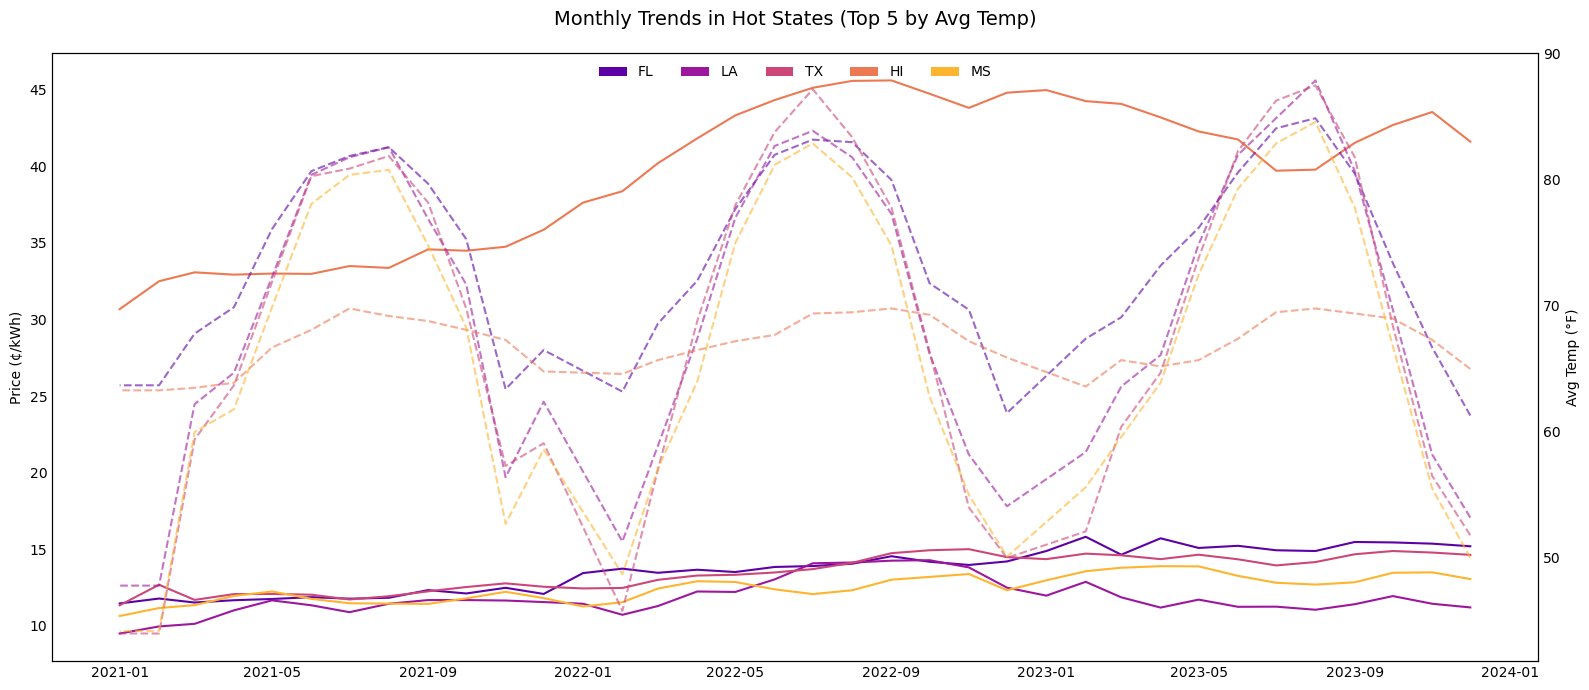

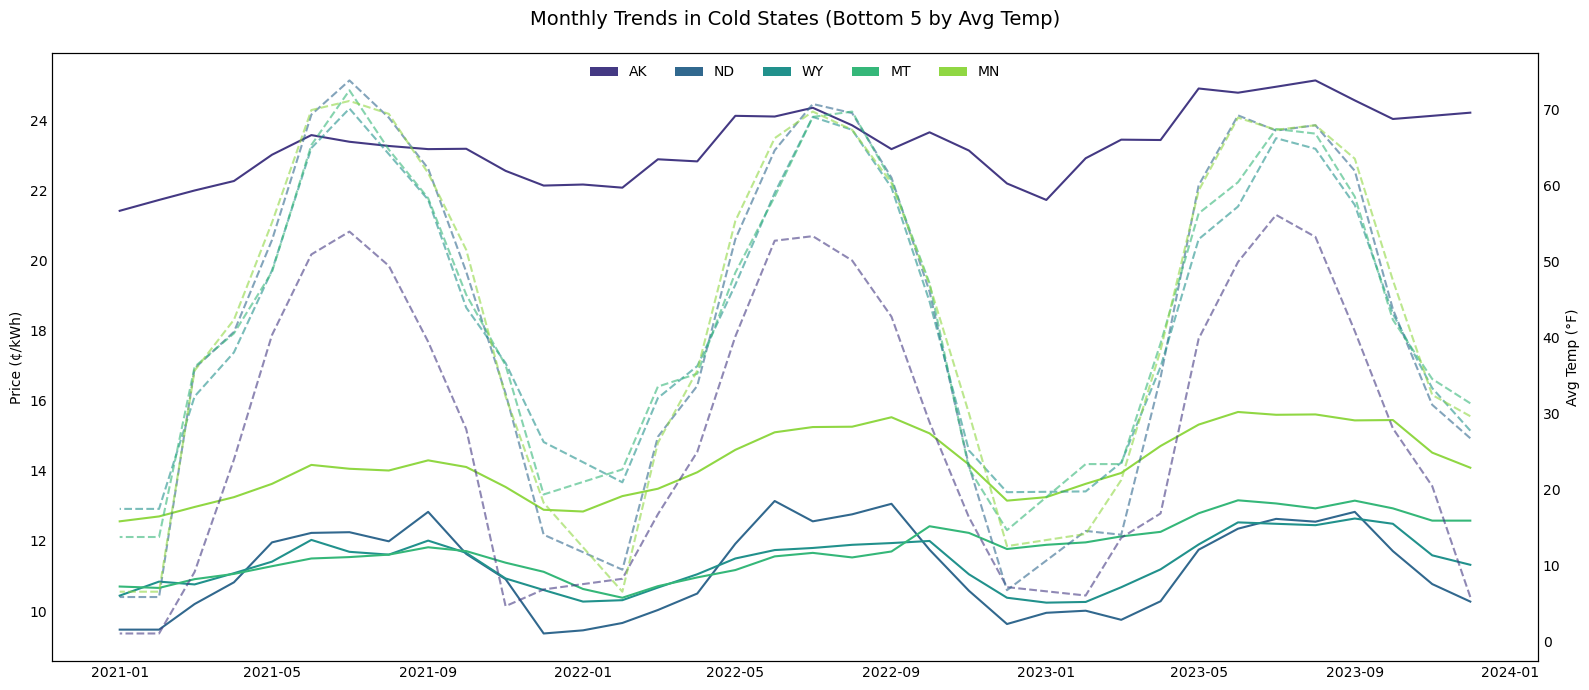

In [83]:
plot_price_temp_dual_axis(hot_states, "Monthly Trends in Hot States (Top 5 by Avg Temp)", colormap="plasma")
plot_price_temp_dual_axis(cold_states, "Monthly Trends in Cold States (Bottom 5 by Avg Temp)", colormap="viridis")


### Insight 2: Seasonal Box Plots for Sales (Consumption) per Customer

In [84]:
# Shows how monthly consumption varies by month across all states.
# Calculate avg_monthly_sales_kwh_per_customer if not already in energy_burden_monthly_pre_calc
if 'avg_monthly_sales_kwh_per_customer' not in energy_burden_monthly.columns:
    energy_burden_monthly['avg_monthly_sales_kwh_per_customer'] = (
        (energy_burden_monthly['sales_mwh'] * 1000) / energy_burden_monthly['customers_count']
    )
    
# Create month name column (in case it is not ordered)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

energy_burden_monthly['month_name'] = pd.to_datetime(energy_burden_monthly['month'], format='%m').dt.strftime('%b')
energy_burden_monthly['month_name'] = pd.Categorical(energy_burden_monthly['month_name'], categories=month_order, ordered=True)


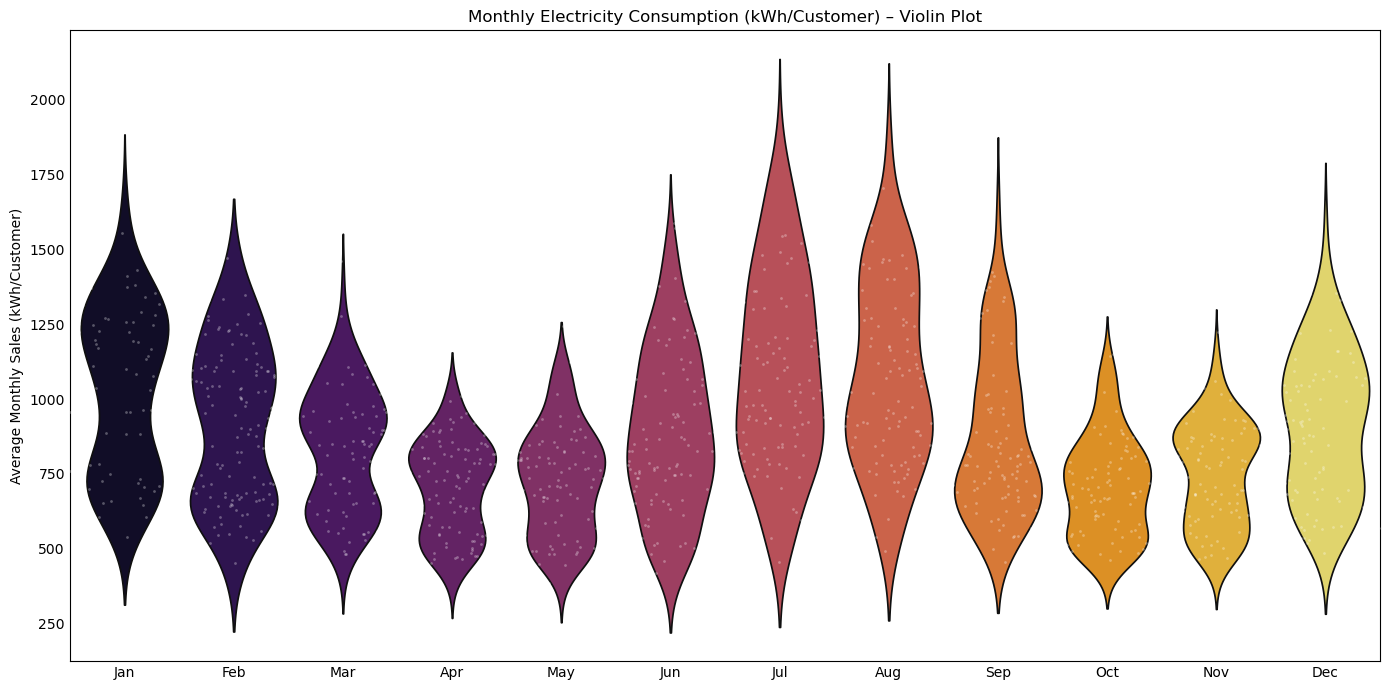

In [85]:
plt.figure(figsize=(14, 7))
sns.violinplot(data=energy_burden_monthly, x='month_name', y='avg_monthly_sales_kwh_per_customer', 
               inner=None, palette='inferno')
sns.stripplot(data=energy_burden_monthly, x='month_name', y='avg_monthly_sales_kwh_per_customer', 
              color='white', size=2, alpha=0.3, jitter=1)

plt.title('Monthly Electricity Consumption (kWh/Customer) – Violin Plot')
plt.xlabel('')
plt.ylabel('Average Monthly Sales (kWh/Customer)')
# Remove ticks for minimal look
plt.tick_params(axis='both', length=0)
# plt.xticks([]) 
plt.tight_layout()
plt.show()

## Visualizing Trends in Merged Annual Dataset 

### Insight 1: Scatter plot of Annual Price vs. Median Household Income

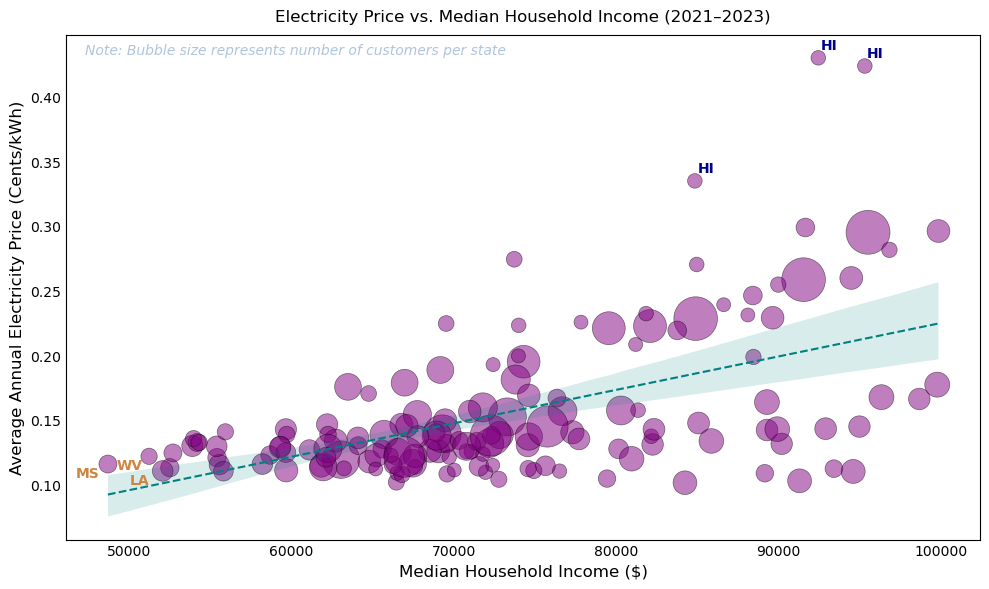

In [86]:
# Sort to get top 3 expensive & bottom 3 income states
top_price_states = energy_burden_annual.sort_values('annual_price_cents_per_kwh', ascending=False).head(3)
low_income_states = energy_burden_annual.sort_values('median_household_income', ascending=True).head(3)

# Base figure
plt.figure(figsize=(10, 6))

# Main scatterplot
sns.scatterplot(data=energy_burden_annual, x='median_household_income', y='annual_price_cents_per_kwh', 
                size='annual_customers_count', sizes=(100, 1000), color='purple', alpha=0.5, 
                edgecolor='black', linewidth=0.5)

# Add regression line (no CI for cleaner look)
sns.regplot(data=energy_burden_annual, x='median_household_income', y='annual_price_cents_per_kwh',
            scatter=False, color='teal', line_kws={'linewidth': 1.5, 'linestyle': '--'})

# Annotate top price states
for _, row in top_price_states.iterrows():
    plt.text(
        row['median_household_income'] + 150,
        row['annual_price_cents_per_kwh'] + 0.007,
        row['state_code'],
        fontsize=10,
        weight='bold',
        color='darkblue'
    )

# Annotate lowest income states
for _, row in low_income_states.iterrows():
    plt.text(
        row['median_household_income'] - 2000,
        row['annual_price_cents_per_kwh'] - 0.01,
        row['state_code'],
        fontsize=10,
        weight='bold',
        color='peru'
    )

# Labels and aesthetics
plt.title('Electricity Price vs. Median Household Income (2021–2023)', fontsize=12, pad=10)
plt.xlabel('Median Household Income ($)', fontsize=12)
plt.ylabel('Average Annual Electricity Price (Cents/kWh)', fontsize=12)
# plt.ticklabel_format(style='plain', axis='x')
plt.tick_params(axis='both', length=0)
plt.figtext(0.3, 0.9, 'Note: Bubble size represents number of customers per state', 
            wrap=True, horizontalalignment='center', fontsize=10, style='italic', color='lightsteelblue')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

### Insight 2: Pairplot of key annual variables (subset)

In [87]:
# Define variables to include
pairplot_vars = [
    'annual_price_cents_per_kwh',
    'median_household_income',
    'avg_annual_temp_f',
    'total_cooling_degree_days','year'
]

# Drop missing values
cleaned_df = energy_burden_annual[pairplot_vars].dropna()
cleaned_df['year'] = cleaned_df['year'].astype(str)

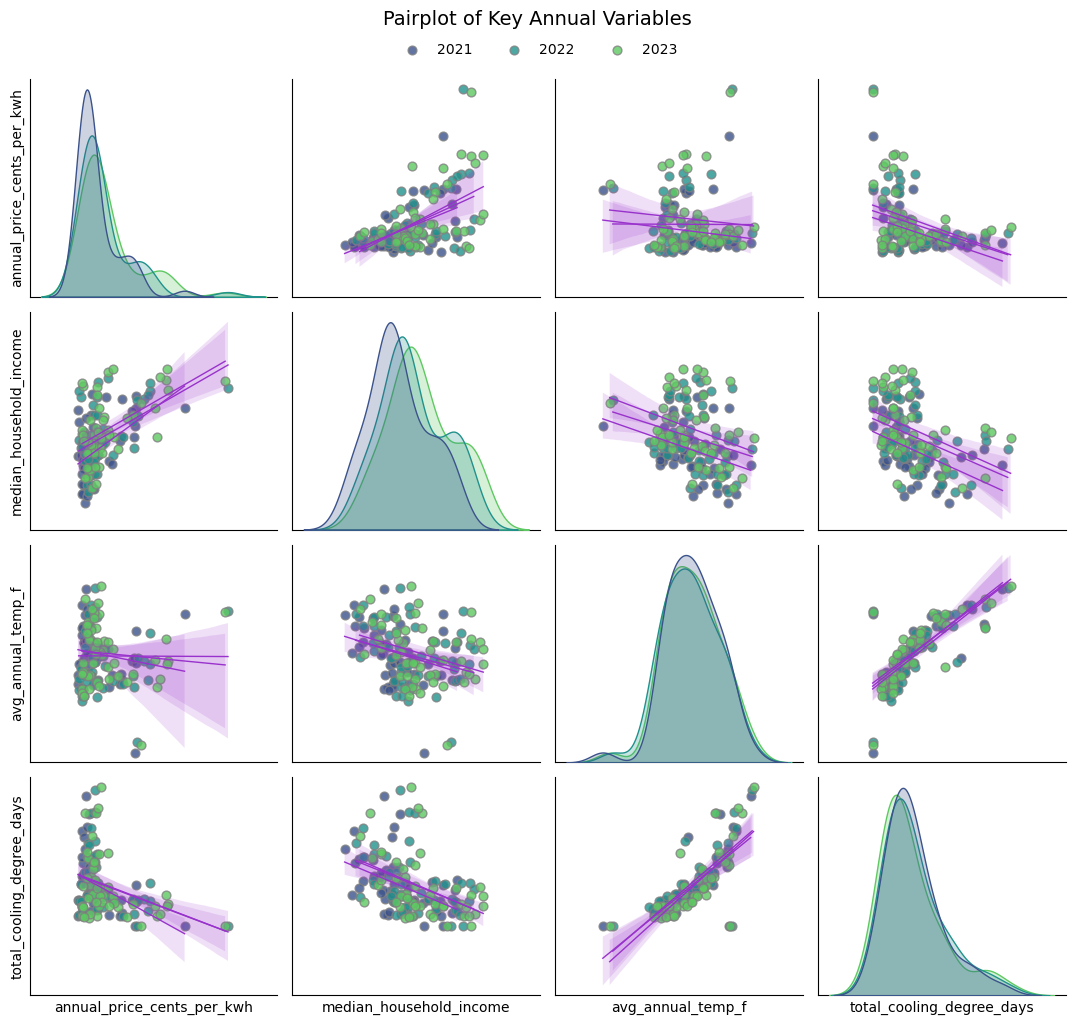

In [88]:
# Create Pairplot
pair_grid = sns.pairplot(
    cleaned_df,
    kind='reg',     
    diag_kind='kde',
    hue='year',
    # markers=["o", "s", "+"],
    plot_kws={
        'scatter_kws': {'alpha': 0.8, 's': 40, 'edgecolor': 'gray'},
        'line_kws': {'color': 'darkorchid', 'linewidth': 1},
    },
    palette='viridis'
)
for ax in pair_grid.axes.flatten():
    if ax:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Remove default legend and add customized one at top-center
if pair_grid._legend is not None:
    pair_grid._legend.remove()

pair_grid.fig.legend(
    handles=pair_grid._legend_data.values(),
    labels=pair_grid._legend_data.keys(),
    # title='Year',
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    ncol=len(cleaned_df['year'].unique()),
    frameon=False
)
# Main title
pair_grid.fig.suptitle('Pairplot of Key Annual Variables', fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


# Energy Burden Analysis

## Computation of Metrics in Monthly Energy Data

In [89]:
# Calculate Average Monthly Sales (Consumption) per Customer in kWh
if 'avg_monthly_sales_kwh_per_customer' not in energy_burden_monthly.columns:
    energy_burden_monthly['avg_monthly_sales_kwh_per_customer'] = (
        (energy_burden_monthly['sales_mwh'] * 1000) / energy_burden_monthly['customers_count']
    )


In [90]:
# Calculate Average Monthly Revenue (Cost) per Customer in Dollars
energy_burden_monthly['avg_monthly_cost_dollars_per_customer'] = (
    (energy_burden_monthly['revenue_thousand_dollars'] * 1000) / energy_burden_monthly['customers_count']
)

# Verify new columns
print("\nEnergy Burden Monthly (Pre-Calculation) with new derived metrics (head):")
energy_burden_monthly.head()


Energy Burden Monthly (Pre-Calculation) with new derived metrics (head):


,year,month,data_status,revenue_thousand_dollars,sales_mwh,customers_count,price_cents_per_kwh,state_code,state_name,avg_consumption_mwh,...,precipitation_inches,temp_avg_f,temp_max_f,temp_min_f,season,month_name,median_household_income,monthly_income,avg_monthly_sales_kwh_per_customer,avg_monthly_cost_dollars_per_customer
0,2023,12,Final,51237.89,211543.65,296928.0,24.22,AK,Alaska,0.712441,...,4.53,5.8,12.6,-0.9,Winter,Dec,86631.0,7219.250000,712.440895,172.559981
1,2023,12,Final,376876.37,2662008.40,2354106.0,14.16,AL,Alabama,1.130794,...,3.71,48.8,60.0,37.5,Winter,Dec,62212.0,5184.333333,1130.793771,160.093203
2,2023,12,Final,171935.62,1489393.10,1466787.0,11.54,AR,Arkansas,1.015412,...,2.75,46.0,56.8,35.2,Winter,Dec,58700.0,4891.666667,1015.411986,117.219215
3,2023,12,Final,348174.75,2415126.40,3102198.0,14.42,AZ,Arizona,0.778521,...,0.92,45.4,58.6,32.2,Winter,Dec,77315.0,6442.916667,778.521036,112.234857
4,2023,12,Final,1906136.00,6546374.70,14151928.0,29.12,CA,California,0.462578,...,3.29,48.1,57.8,38.4,Winter,Dec,95521.0,7960.083333,462.578293,134.690906


## Computation of Annual Electricity Cost per Customer

In [91]:
# Aggregate monthly costs to get annual cost per customer
# Group by state and year from the monthly burden data
annual_cost_per_customer = energy_burden_monthly.groupby(['state_code', 'state_name', 'year']).agg(
    total_annual_cost_dollars_per_customer=('avg_monthly_cost_dollars_per_customer', 'sum')
).reset_index()

In [92]:
# Merge eannual data 
energy_burden_annual = pd.merge(
    energy_burden_annual,
    annual_cost_per_customer,
    on=['state_code', 'state_name', 'year'],
    how='left'
)

## Computation of Energy Burden (%)

In [93]:
print("\nEnergy Burden Annual with Total Annual Cost per Customer (head):")
energy_burden_annual.head()


Energy Burden Annual with Total Annual Cost per Customer (head):


,state_code,state_name,year,annual_revenue_thousand_dollars,annual_sales_mwh,annual_customers_count,annual_price_cents_per_kwh,total_cooling_degree_days,total_heating_degree_days,total_precipitation_inches,avg_annual_temp_f,avg_annual_temp_max_f,avg_annual_temp_min_f,median_household_income,total_annual_cost_dollars_per_customer
0,AK,Alaska,2021,469885.58,2083911.02,2.924495e+05,0.225483,0.0,0.0,35.54,27.927273,35.472727,20.363636,77845.0,1606.934581
1,AK,Alaska,2022,473751.32,2050472.01,2.943712e+05,0.231045,0.0,0.0,39.42,30.990909,38.381818,23.581818,88121.0,1609.632093
2,AK,Alaska,2023,490072.41,2050666.99,2.961921e+05,0.238982,0.0,0.0,39.32,30.036364,37.400000,22.645455,86631.0,1654.746554
3,AL,Alabama,2021,4092368.37,31585153.10,2.308229e+06,0.129566,1876.0,1784.0,61.44,65.800000,76.754545,54.854545,53913.0,1773.578215
4,AL,Alabama,2022,4690788.22,32923573.20,2.329559e+06,0.142475,2036.0,1920.0,53.02,65.845455,77.445455,54.227273,59674.0,2013.266910


In [94]:
# For Annual Energy Burden:
# Energy Burden (%) = (Total Annual Electricity Cost per Customer / Median Household Income) * 100
energy_burden_annual['energy_burden_percent'] = (
    (energy_burden_annual['total_annual_cost_dollars_per_customer'] / energy_burden_annual['median_household_income']) * 100
)

In [95]:
# For Monthly Energy Burden:
# Energy Burden (%) = (Average Monthly Electricity Cost per Customer / Monthly Income) * 100
energy_burden_monthly['energy_burden_percent'] = (
    (energy_burden_monthly['avg_monthly_cost_dollars_per_customer'] / energy_burden_monthly['monthly_income']) * 100
)

## Advanced Analytical Insights

### Overall US Energy Burden Trends (Annual)

In [96]:
# Calculate the average energy burden across all states for each year
us_avg_annual_burden = energy_burden_annual.groupby('year')['energy_burden_percent'].mean().reset_index()

# FIX: Ensure 'year' column is integer type for xticks
us_avg_annual_burden['year'] = us_avg_annual_burden['year'].astype(int)

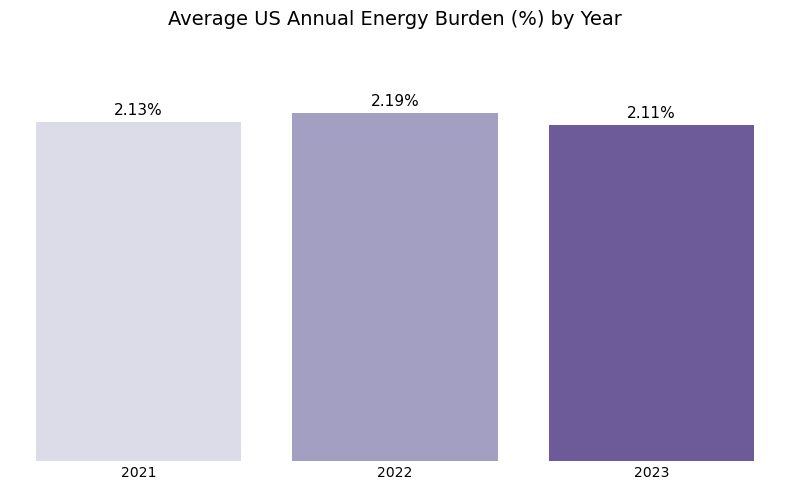

In [97]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=us_avg_annual_burden, x='year', y='energy_burden_percent', palette='Purples')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=11, padding=3)

plt.title('Average US Annual Energy Burden (%) by Year', fontsize=14)
# Remove axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
plt.tick_params(axis='both', length=0)
# ax.set_xticks([])
ax.set_yticks([])
plt.ylim(0, us_avg_annual_burden['energy_burden_percent'].max() + 0.5)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Top/Bottom States by Average Annual Energy Burden

In [98]:
# Group by state to get average energy burden
avg_burden = energy_burden_annual.groupby(['state_code', 'state_name'])['energy_burden_percent'].mean().reset_index()
# Create a custom hovertext column for the choropleth map
avg_burden['hover_text'] = avg_burden.apply(
    lambda row: f"State: {row['state_code']}<br>Energy Burden: {row['energy_burden_percent']:.2f}%", 
    axis=1)

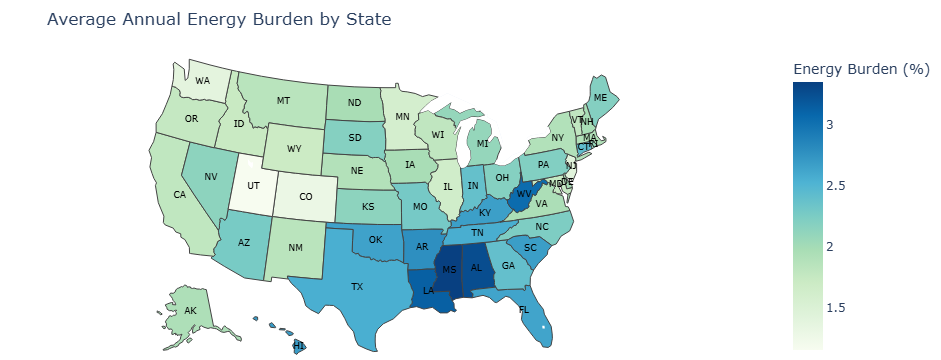

In [99]:
# Create the choropleth map to display % Energy Burden Across US States
fig = go.Figure(data=go.Choropleth(
    locations=avg_burden['state_code'],
    z=avg_burden['energy_burden_percent'],
    locationmode='USA-states',
    colorscale='GnBu',
    colorbar_title="Energy Burden (%)",
    text=avg_burden['hover_text'], 
    hoverinfo='text'               
))

# Add the state codes as visible text labels
fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    locations=avg_burden['state_code'],
    text=avg_burden['state_code'],
    mode='text',
    textfont=dict(color='black', size=9),
    hoverinfo='skip',        
    showlegend=False
))
# Final layout updates
fig.update_layout(
    title_text="Average Annual Energy Burden by State ",
    geo=dict(
        scope='usa',
        showlakes=True,
        lakecolor='rgb(255, 255, 255)',
        projection_type='albers usa'
    ),
    margin=dict(r=0, l=0, b=0, t=50)
)

fig.show()

In [100]:
# Calculate the average annual energy burden per state across all years
avg_annual_burden_per_state = energy_burden_annual.groupby('state_name')['energy_burden_percent'].mean().sort_values(ascending=False).reset_index()

# Select top 10 and bottom 10 states
top_10_states = avg_annual_burden_per_state.head(5)
bottom_10_states = avg_annual_burden_per_state.tail(5).sort_values(ascending=True, by='energy_burden_percent')

In [101]:
# Print the results in a formatted way using pandas' to_markdown()
print("   High Energy Burden States (Top 5)\n")
print(top_10_states.to_markdown(index=False, floatfmt=".1f"))

print("\n    Low Energy Burden States (Bottom 5)\n")
print(bottom_10_states.to_markdown(index=False, floatfmt=".1f"))


   High Energy Burden States (Top 5)

| state_name    |   energy_burden_percent |
|:--------------|------------------------:|
| Mississippi   |                     3.4 |
| Alabama       |                     3.3 |
| Louisiana     |                     3.1 |
| West Virginia |                     3.0 |
| Arkansas      |                     2.8 |

    Low Energy Burden States (Bottom 5)

| state_name   |   energy_burden_percent |
|:-------------|------------------------:|
| Utah         |                     1.2 |
| Colorado     |                     1.3 |
| Washington   |                     1.4 |
| New Jersey   |                     1.4 |
| Minnesota    |                     1.6 |


### Seasonal Patterns of Energy Burden, Price, and Consumption (Monthly)

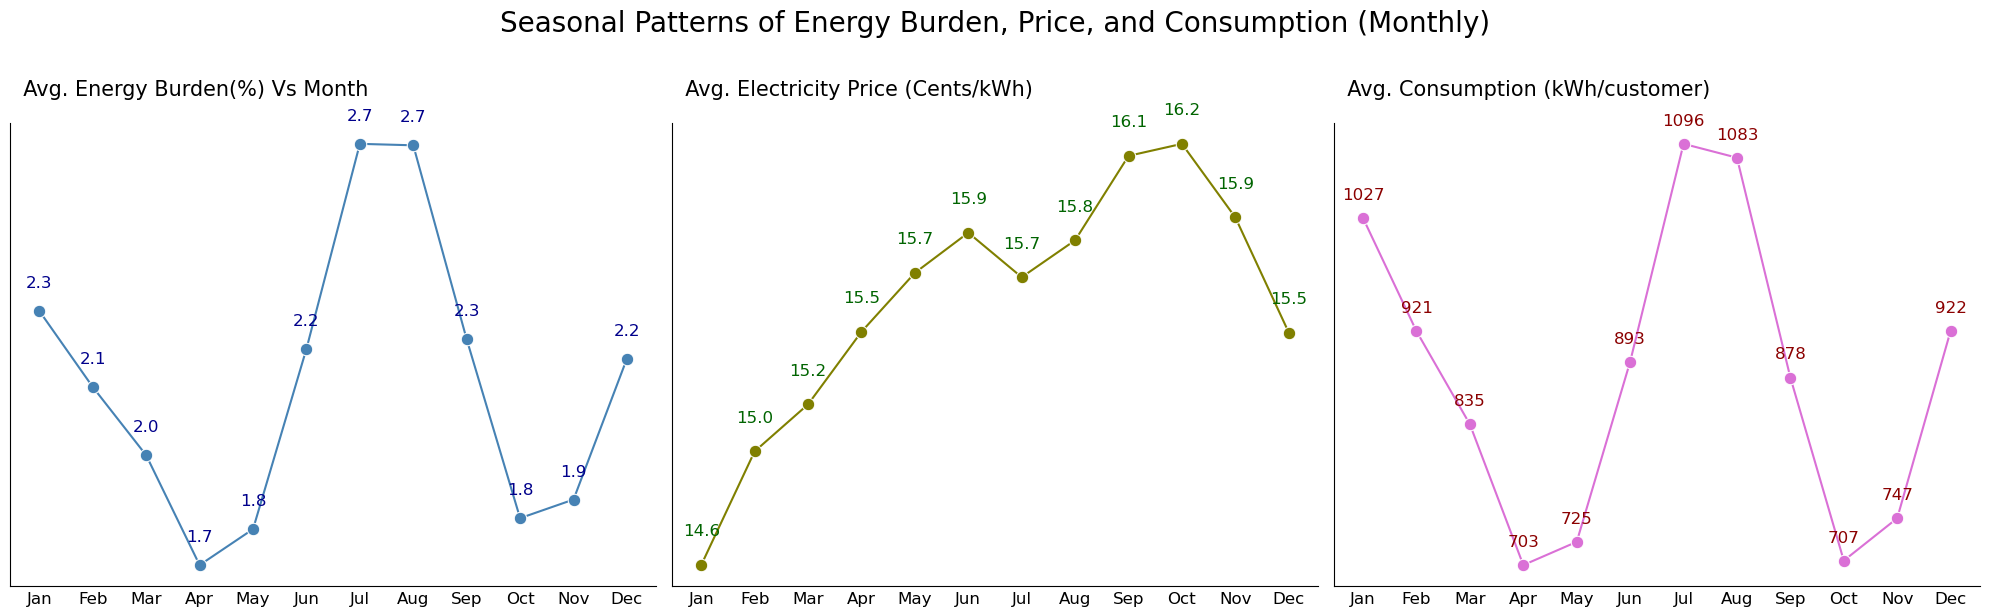

In [102]:
energy_burden_monthly['month'] = energy_burden_monthly['month'].astype(int)

# Aggregate by month and season
monthly_avg_metrics = energy_burden_monthly.groupby(['month','month_name']).agg(
    avg_burden=('energy_burden_percent', 'mean'),
    avg_price=('price_cents_per_kwh', 'mean'),
    avg_consumption=('avg_monthly_sales_kwh_per_customer', 'mean')).reset_index()

# Create month name column (in case it is not ordered)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_avg_metrics['month_name'] = pd.to_datetime(monthly_avg_metrics['month'], format='%m').dt.strftime('%b')
monthly_avg_metrics['month_name'] = pd.Categorical(monthly_avg_metrics['month_name'], categories=month_order, ordered=True)

plt.figure(figsize=(20, 6))
plt.suptitle('Seasonal Patterns of Energy Burden, Price, and Consumption (Monthly)', fontsize=20, y=1.02)

plt.subplot(1, 3, 1)
sns.lineplot(data=monthly_avg_metrics, x='month_name', y='avg_burden', marker='o', color='steelblue', markersize= 9)
plt.title('  Avg. Energy Burden(%) Vs Month', fontsize=15, loc= 'left', pad = 20)
for _, row in monthly_avg_metrics.iterrows():
    if np.isfinite(row['avg_burden']):
        plt.text(row['month_name'], row['avg_burden'] + 0.05, f"{row['avg_burden']:.1f}", 
                 color='darkblue', ha='center', fontsize=12, va= 'bottom')
plt.xlabel('')
plt.ylabel('')
plt.tick_params(axis='both', length=0, labelsize=12)
plt.yticks([]) 

plt.subplot(1, 3, 2)
sns.lineplot(data=monthly_avg_metrics, x='month_name', y='avg_price', marker='o', color='olive', markersize= 9)
plt.title('  Avg. Electricity Price (Cents/kWh)', fontsize=15, loc= 'left', pad = 20)
for _, row in monthly_avg_metrics.iterrows():
    if np.isfinite(row['avg_price']):
        plt.text(row['month_name'], row['avg_price'] + 0.1, f"{row['avg_price']:.1f}", 
                 color='darkgreen', ha='center', fontsize=12, va= 'bottom')
plt.xlabel('')
plt.ylabel('')
plt.tick_params(axis='both', length=0, labelsize=12)
plt.yticks([]) 

plt.subplot(1, 3, 3)
sns.lineplot(data=monthly_avg_metrics, x='month_name', y='avg_consumption',marker='o', color='orchid', markersize= 9)
plt.title('  Avg. Consumption (kWh/customer)', fontsize=15, loc= 'left', pad = 20)
for _, row in monthly_avg_metrics.iterrows():
    if np.isfinite(row['avg_consumption']):
        plt.text(row['month_name'], row['avg_consumption'] + 15, f"{row['avg_consumption']:.0f}", 
                 color='darkred', ha='center', fontsize=12, va = 'bottom')
plt.xlabel('')
plt.ylabel('')
plt.tick_params(axis='both', length=0, labelsize=12)
plt.yticks([]) 
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()

# Predictive Modeling and Explainability

## Correlation Matrix of Final Metrics (Annual Data)

In [103]:
energy_burden_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   state_code                              150 non-null    object 
 1   state_name                              150 non-null    object 
 2   year                                    150 non-null    Int64  
 3   annual_revenue_thousand_dollars         150 non-null    float64
 4   annual_sales_mwh                        150 non-null    float64
 5   annual_customers_count                  150 non-null    float64
 6   annual_price_cents_per_kwh              150 non-null    float64
 7   total_cooling_degree_days               150 non-null    float64
 8   total_heating_degree_days               150 non-null    float64
 9   total_precipitation_inches              150 non-null    float64
 10  avg_annual_temp_f                       150 non-null    float6

In [104]:
final_correlation_cols = [
    'energy_burden_percent',
    'median_household_income',
    'annual_price_cents_per_kwh',
    'annual_sales_mwh', # Total annual consumption
    'avg_annual_temp_f',
    'total_cooling_degree_days',
    'total_heating_degree_days',
    'total_precipitation_inches'
]

In [105]:
correlation_cols = [
    'energy_burden_percent',
    'median_household_income',
    'annual_price_cents_per_kwh',
    'annual_sales_mwh',
    'avg_annual_temp_f',
    'total_cooling_degree_days',
    'total_heating_degree_days',
    'total_precipitation_inches'
]

# Label map for readability
label_map = {
    'energy_burden_percent': 'Energy Burden (%)',
    'median_household_income': 'Household Income ($)',
    'annual_price_cents_per_kwh': 'Price (¢/kWh)',
    'annual_sales_mwh': 'Annual Sales (MWh)',
    'avg_annual_temp_f': 'Avg Temp (°F)',
    'total_cooling_degree_days': 'Cooling Degree Days',
    'total_heating_degree_days': 'Heating Degree Days',
    'total_precipitation_inches': 'Precipitation (in)'
}

In [106]:
# Create correlation matrix
corr_data = energy_burden_annual[correlation_cols]
corr_matrix = corr_data.corr().rename(columns=label_map, index=label_map)

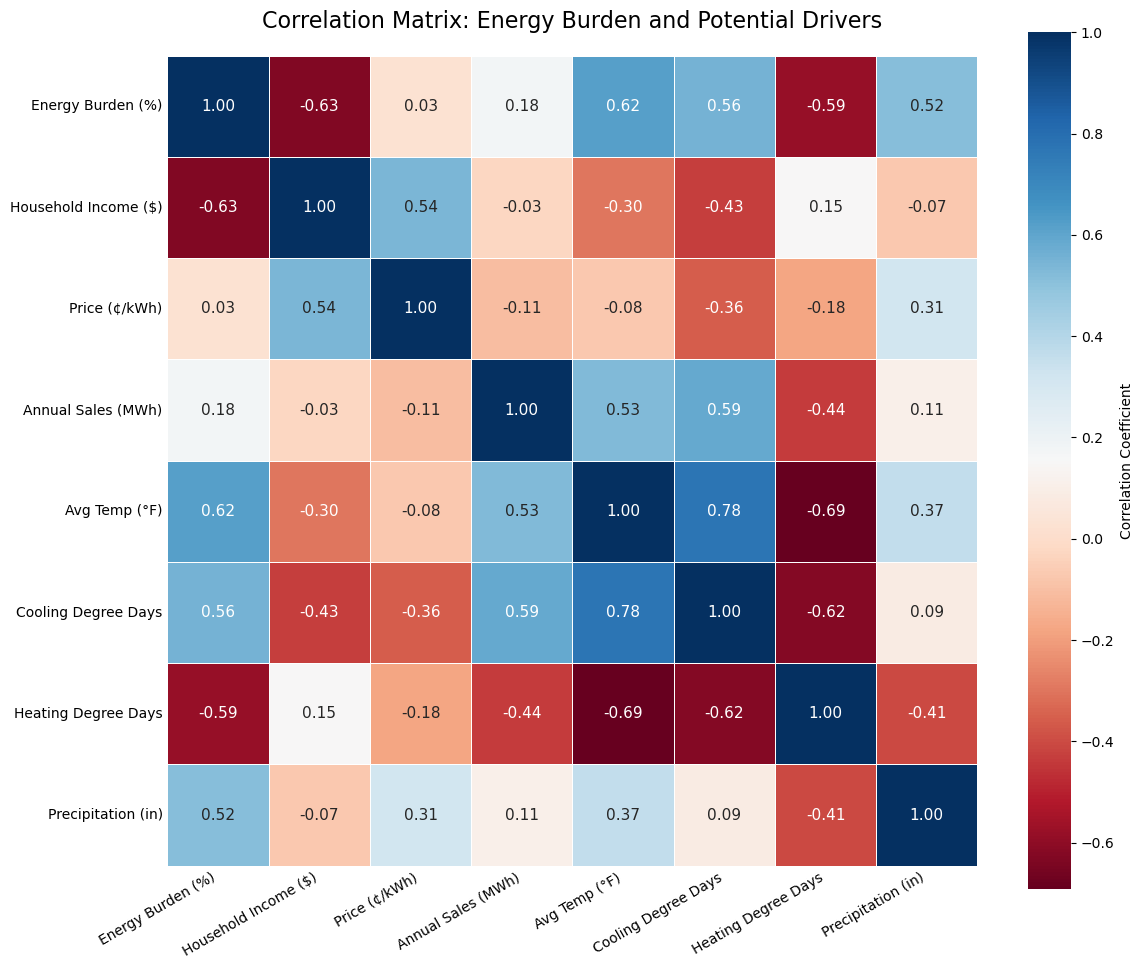

In [107]:
# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu', linewidths=0.5, square=True,
            cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={"fontsize": 11})

plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tick_params(axis='both', length=0, labelsize=10)
plt.title('Correlation Matrix: Energy Burden and Potential Drivers', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [108]:
corr_matrix['Energy Burden (%)']

Energy Burden (%)       1.000000
Household Income ($)   -0.629444
Price (¢/kWh)           0.025314
Annual Sales (MWh)      0.179837
Avg Temp (°F)           0.618367
Cooling Degree Days     0.556858
Heating Degree Days    -0.585781
Precipitation (in)      0.515051
Name: Energy Burden (%), dtype: float64

## Regression Analysis: Energy Burden vs. Key Drivers (Annual Data)

In [109]:
# Define dependent and independent variables
# Drop NaNs for regression, as OLS doesn't handle them by default.

regression_df = energy_burden_annual.dropna(subset=[
    'energy_burden_percent', 'median_household_income',
    'total_cooling_degree_days', 'annual_price_cents_per_kwh'
]).copy()

In [110]:
# Add a constant to the independent variables for the intercept
X = regression_df[[
    'median_household_income',
    'annual_price_cents_per_kwh',
    'avg_annual_temp_f',
    'total_cooling_degree_days'
]]

In [111]:
y = regression_df['energy_burden_percent']

In [112]:
# Add constant for intercept
X = sm.add_constant(X)
# X_with_const = sm.add_constant(X)

In [113]:
# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

In [114]:
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     energy_burden_percent   R-squared:                       0.766
Model:                               OLS   Adj. R-squared:                  0.760
Method:                    Least Squares   F-statistic:                     118.9
Date:                   Sun, 10 Aug 2025   Prob (F-statistic):           9.55e-45
Time:                           23:25:14   Log-Likelihood:                0.69801
No. Observations:                    150   AIC:                             8.604
Df Residuals:                        145   BIC:                             23.66
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

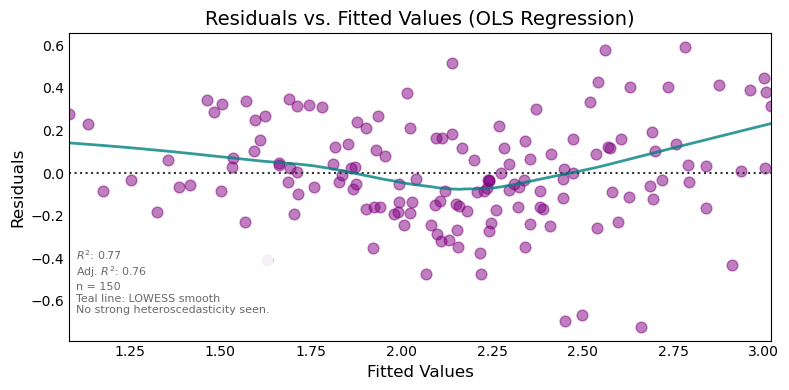

In [115]:
# Visualize residuals to check model assumptions
plt.figure(figsize=(8, 4))

sns.residplot(x=results.fittedvalues, y=results.resid, lowess=True,
              scatter_kws={'s': 60, 'color': 'purple','alpha': 0.5},
              line_kws={'color': 'teal', 'lw': 2,'alpha': 0.8})

# Add R-squared and model stats
textstr = '\n'.join((
    f'$R^2$: {results.rsquared:.2f}',
    f'Adj. $R^2$: {results.rsquared_adj:.2f}',
    f'n = {int(results.nobs)}',
    'Teal line: LOWESS smooth',
    'No strong heteroscedasticity seen.'
))

plt.gca().text(0.01, 0.3, textstr, transform=plt.gca().transAxes, fontsize=8,color='dimgray', 
               verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white',edgecolor='none',alpha=0.9))


plt.title('Residuals vs. Fitted Values (OLS Regression)', fontsize=14)
plt.xlabel('Fitted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.tick_params(axis='both', which='both', length=0)
# sns.despine()  # Optional: remove spines

plt.tight_layout()
plt.show()

## SHAP Analysis for Model Interpretability

In [116]:
# Define prediction function from statsmodels result
predict_fn = lambda x: results.predict(sm.add_constant(x))

In [117]:
# Create a SHAP explainer for the OLS model
explainer = shap.Explainer(predict_fn, X)

In [118]:
# Calculate SHAP values for the regression_df (the data used for fitting)
shap_values = explainer(X)

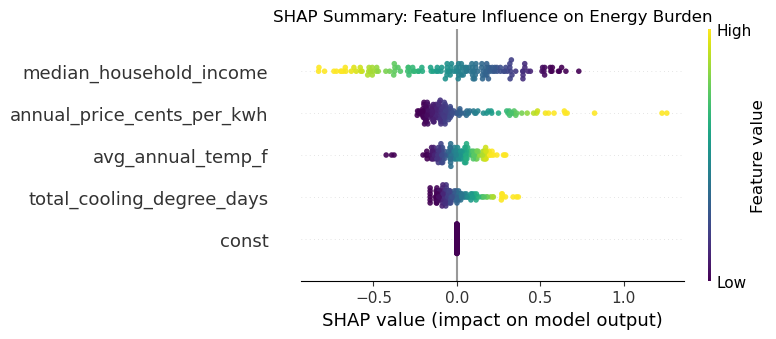

In [119]:
shap.summary_plot(shap_values, plot_type="dot", cmap="viridis", alpha=0.9, show=False)
plt.title('SHAP Summary: Feature Influence on Energy Burden')
plt.tight_layout()
plt.show()

## SHAP Dependence Plots - How a single feature affects the prediction
**Shows the relationship between a feature's value and its impact on the prediction**

In [120]:
# Extract values and feature names for older plotting compatibility
shap_vals = shap_values.values  # shape: (n_samples, n_features)

NameError: name 'features' is not defined

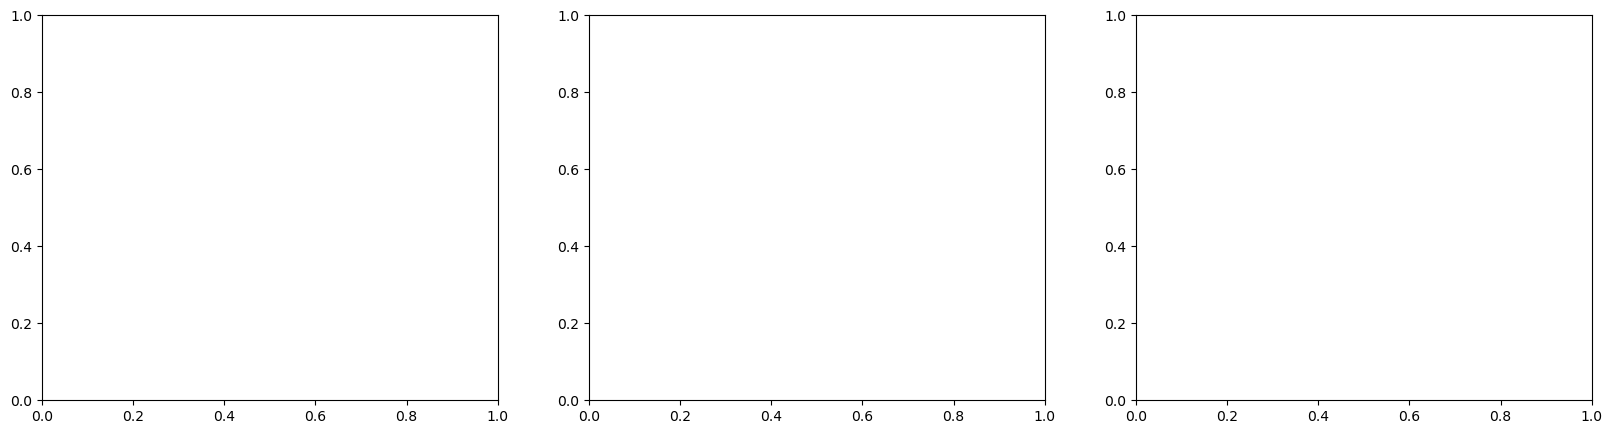

In [121]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
interaction_features = ["median_household_income", "annual_price_cents_per_kwh", "avg_annual_temp_f"]

for i, feat in enumerate(features):
    interaction_index = interaction_features[i]
    
    # Create the SHAP dependence plot
    shap.plots._scatter.dependence_legacy(
        feat, 
        shap_vals, 
        X, 
        interaction_index=interaction_index, 
        cmap="magma", 
        ax=axs[i], 
        show=False,
        dot_size=30,
        alpha=0.8
    )
    
    # Set the labels and title for the main subplot
    axs[i].set_xlabel(feat.replace('_', ' ').title(), fontsize=12)
    axs[i].set_ylabel(f"SHAP Value for {feat.replace('_', ' ').title()}", fontsize=12)
    axs[i].set_title(f"{feat.replace('_', ' ').title()}", fontsize=14)
    fig.colorbar(axs[i].collections[0], ax=axs[i], label=feat.replace('_', ' ').title())
    # Access and rename the colorbar.
    # The last added axes object is the colorbar for the current plot.
    cbar = fig.axes[-1]
    
    # Generate the desired title for the colorbar
    cbar_title = interaction_index.replace('_', ' ').title()
    cbar.set_ylabel(cbar_title, fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("shap_dependence_plot_high_quality.png", dpi=300, bbox_inches='tight')
plt.show()

# Summary and Takeaways

__Income is the strongest determinant of energy burden:__ Across all analyses, lower median household income is consistently linked to higher energy burden, with a clear linear relationship confirmed by SHAP values.

__Electricity prices amplify burden in high-cost regions:__ Although price alone shows weak correlation with burden, in combination with low income it significantly intensifies affordability challenges—particularly in island and coastal states.

__Climate consistently increases costs in warmer regions:__ Higher average annual temperatures and greater cooling degree days elevate household energy costs, with the effect increasing steadily across the temperature range

__Burden hotspots are persistent and structural:__ Southern states like Mississippi, Alabama, and Louisiana repeatedly rank among the highest-burden states, driven by a mix of low incomes, high cooling demand, and structural economic factors.

__Relationships are largely linear and predictable:__ Both regression diagnostics and SHAP dependence plots indicate minimal interaction effects or thresholds, suggesting that income, price, and temperature influence burden in a steady, proportional manner.
   
The analysis reveals clear geographic and socio-economic disparities in energy burden across the United States. States with higher electricity prices and lower household incomes tend to experience a disproportionately higher share of income spent on energy, with climate factors such as higher cooling demand further intensifying the burden in certain regions. Median household income, annual electricity price, and climate variables emerged as the strongest predictors of energy burden, with largely linear relationships to the outcome. These results underscore the persistent nature of energy cost inequities and highlight the multifaceted drivers behind them.